In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# YOLO v5

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
# !git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16960, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 16960 (delta 79), reused 95 (delta 45), pack-reused 16805 (from 1)
Receiving objects: 100% (16960/16960), 15.71 MiB | 21.11 MiB/s, done.
Resolving deltas: 100% (11612/11612), done.
/content/yolov5


In [5]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch
from IPython.display import Image # Import the Image class from the IPython.display module

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.6/873.6 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00
Setup complete. Using torch 2.4.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [6]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Zs41hUNxQeU2M6ZZDQ4c")
project = rf.workspace("thesis-3r986").project("leather-defect-detection-ofz0a")
version = project.version(5)
dataset = version.download("yolov5")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Leather-Defect-Detection-5 in yolov5pytorch:: 100%|██████████| 3928/3928 [00:02<00:00, 1924.60it/s]


In [7]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [8]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# Ultralytics YOLOv5 🚀, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4],

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [11]:
# train yolov5s on custom data for 200 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 800 --batch 16 --epochs 200 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
    178/199      6.61G    0.02779    0.01771   0.003563         51        800:  43% 49/113 [00:21<00:30,  2.13it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    178/199      6.61G     0.0278    0.01774   0.003514         48        800:  44% 50/113 [00:22<00:27,  2.28it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    178/199      6.61G    0.02793     0.0178   0.003479         46        800:  45% 51/113 [00:22<00:26,  2.37it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp

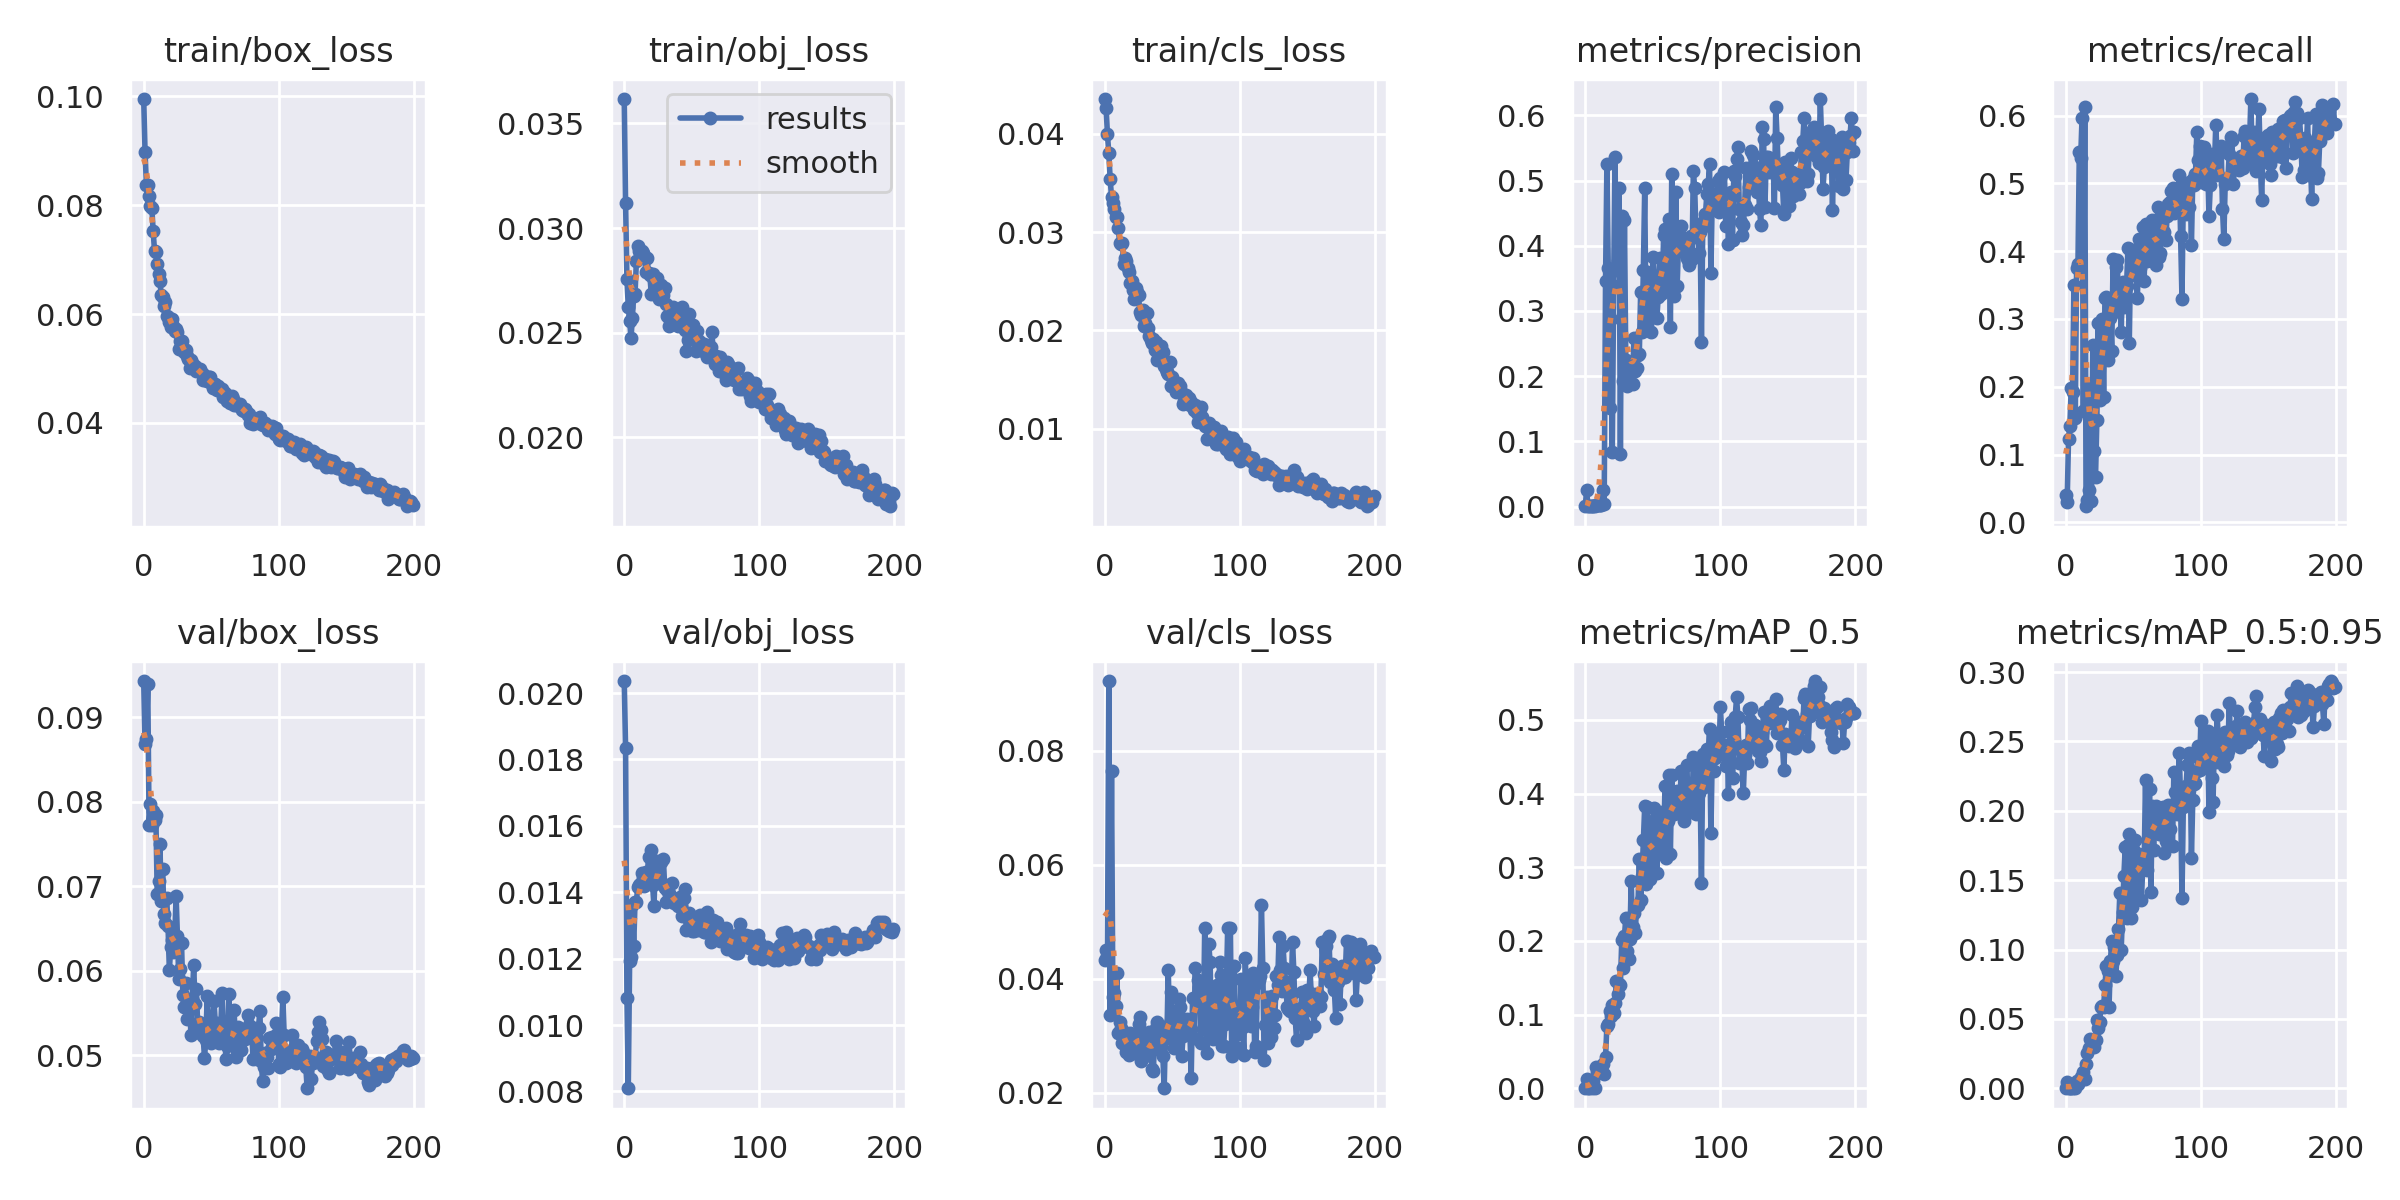

In [12]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

In [13]:
dataset.location

'/content/yolov5/Leather-Defect-Detection-5'

In [14]:
WEIGHTS_BEST = "/content/yolov5/runs/train/yolov5s_results/weights/best.pt"
!python val.py --weights $WEIGHTS_BEST --batch 32 --data {dataset.location}/data.yaml --name 'validation_on_test_data' --augment

val: data=/content/yolov5/Leather-Defect-Detection-5/data.yaml, weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=validation_on_test_data, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-368-gb163ff8d Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7254609 parameters, 0 gradients
val: Scanning /content/yolov5/Leather-Defect-Detection-5/valid/labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100% 59/59 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0% 0/2 [00:00<?, ?it/s]WARNING ⚠️ NMS time limit 2.100s exceeded
                 Class     Images  Instances          P          R      mAP50   mAP

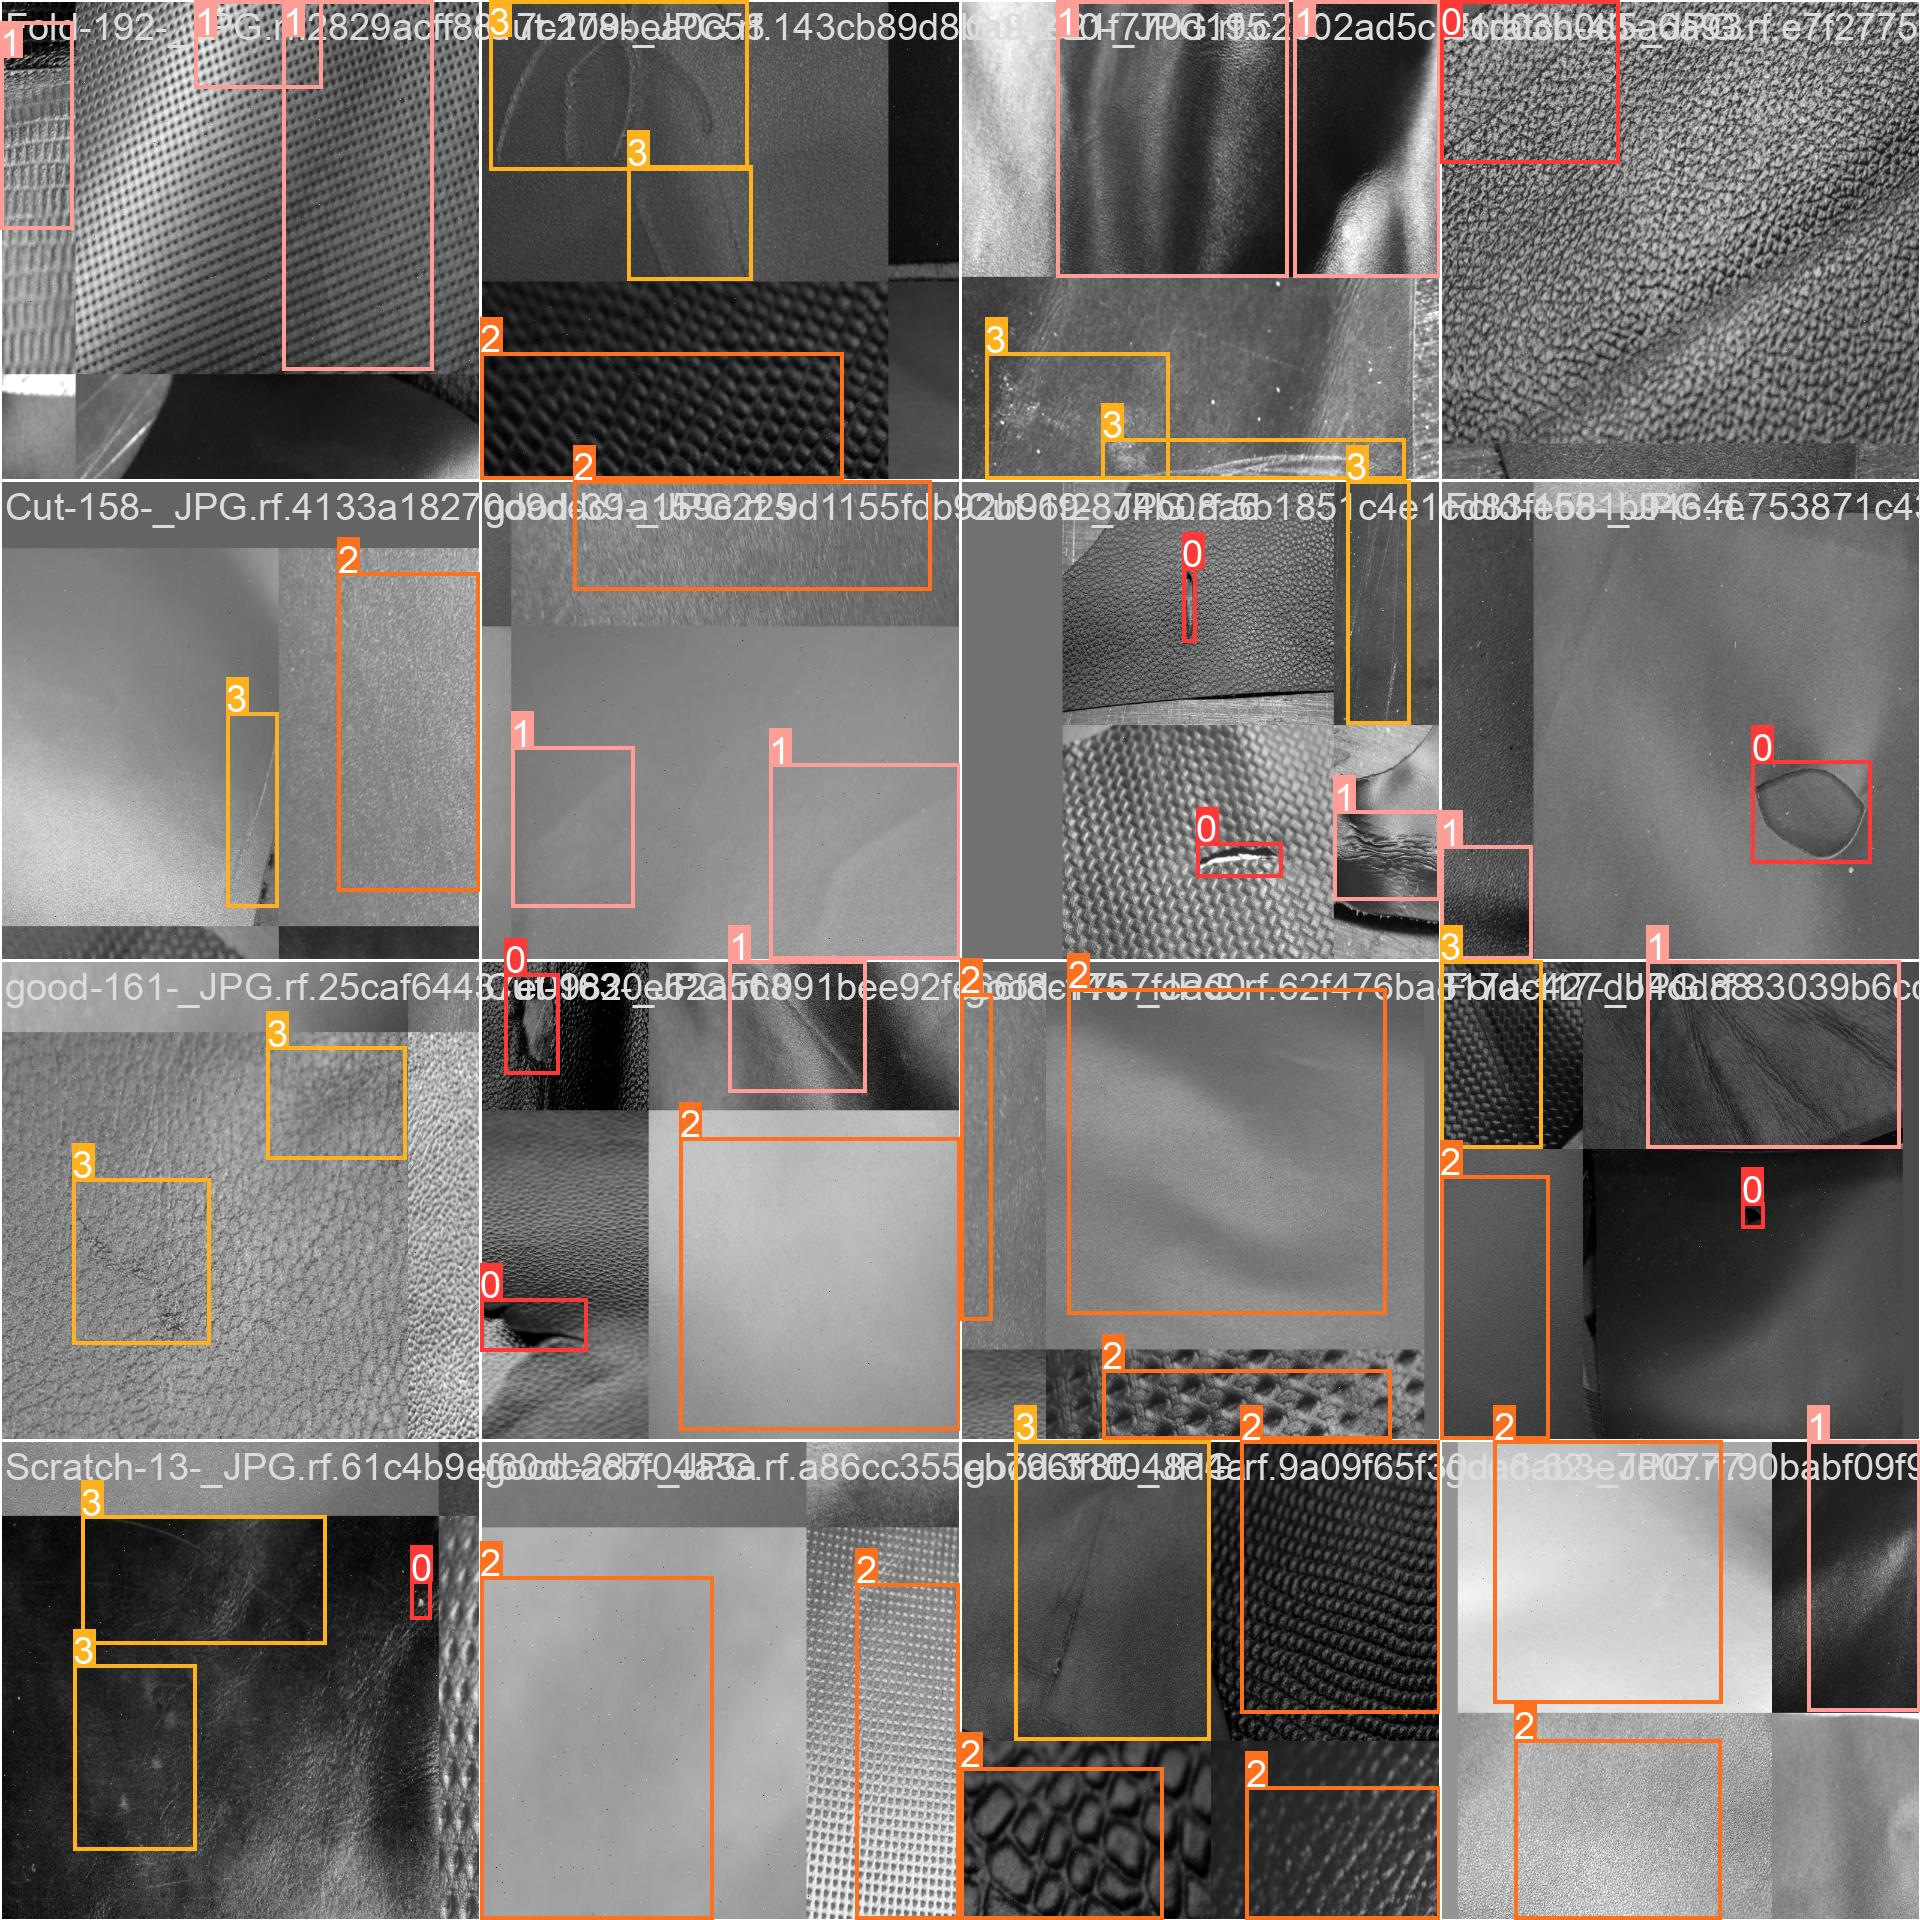

In [15]:
# print out an augmented training example

Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

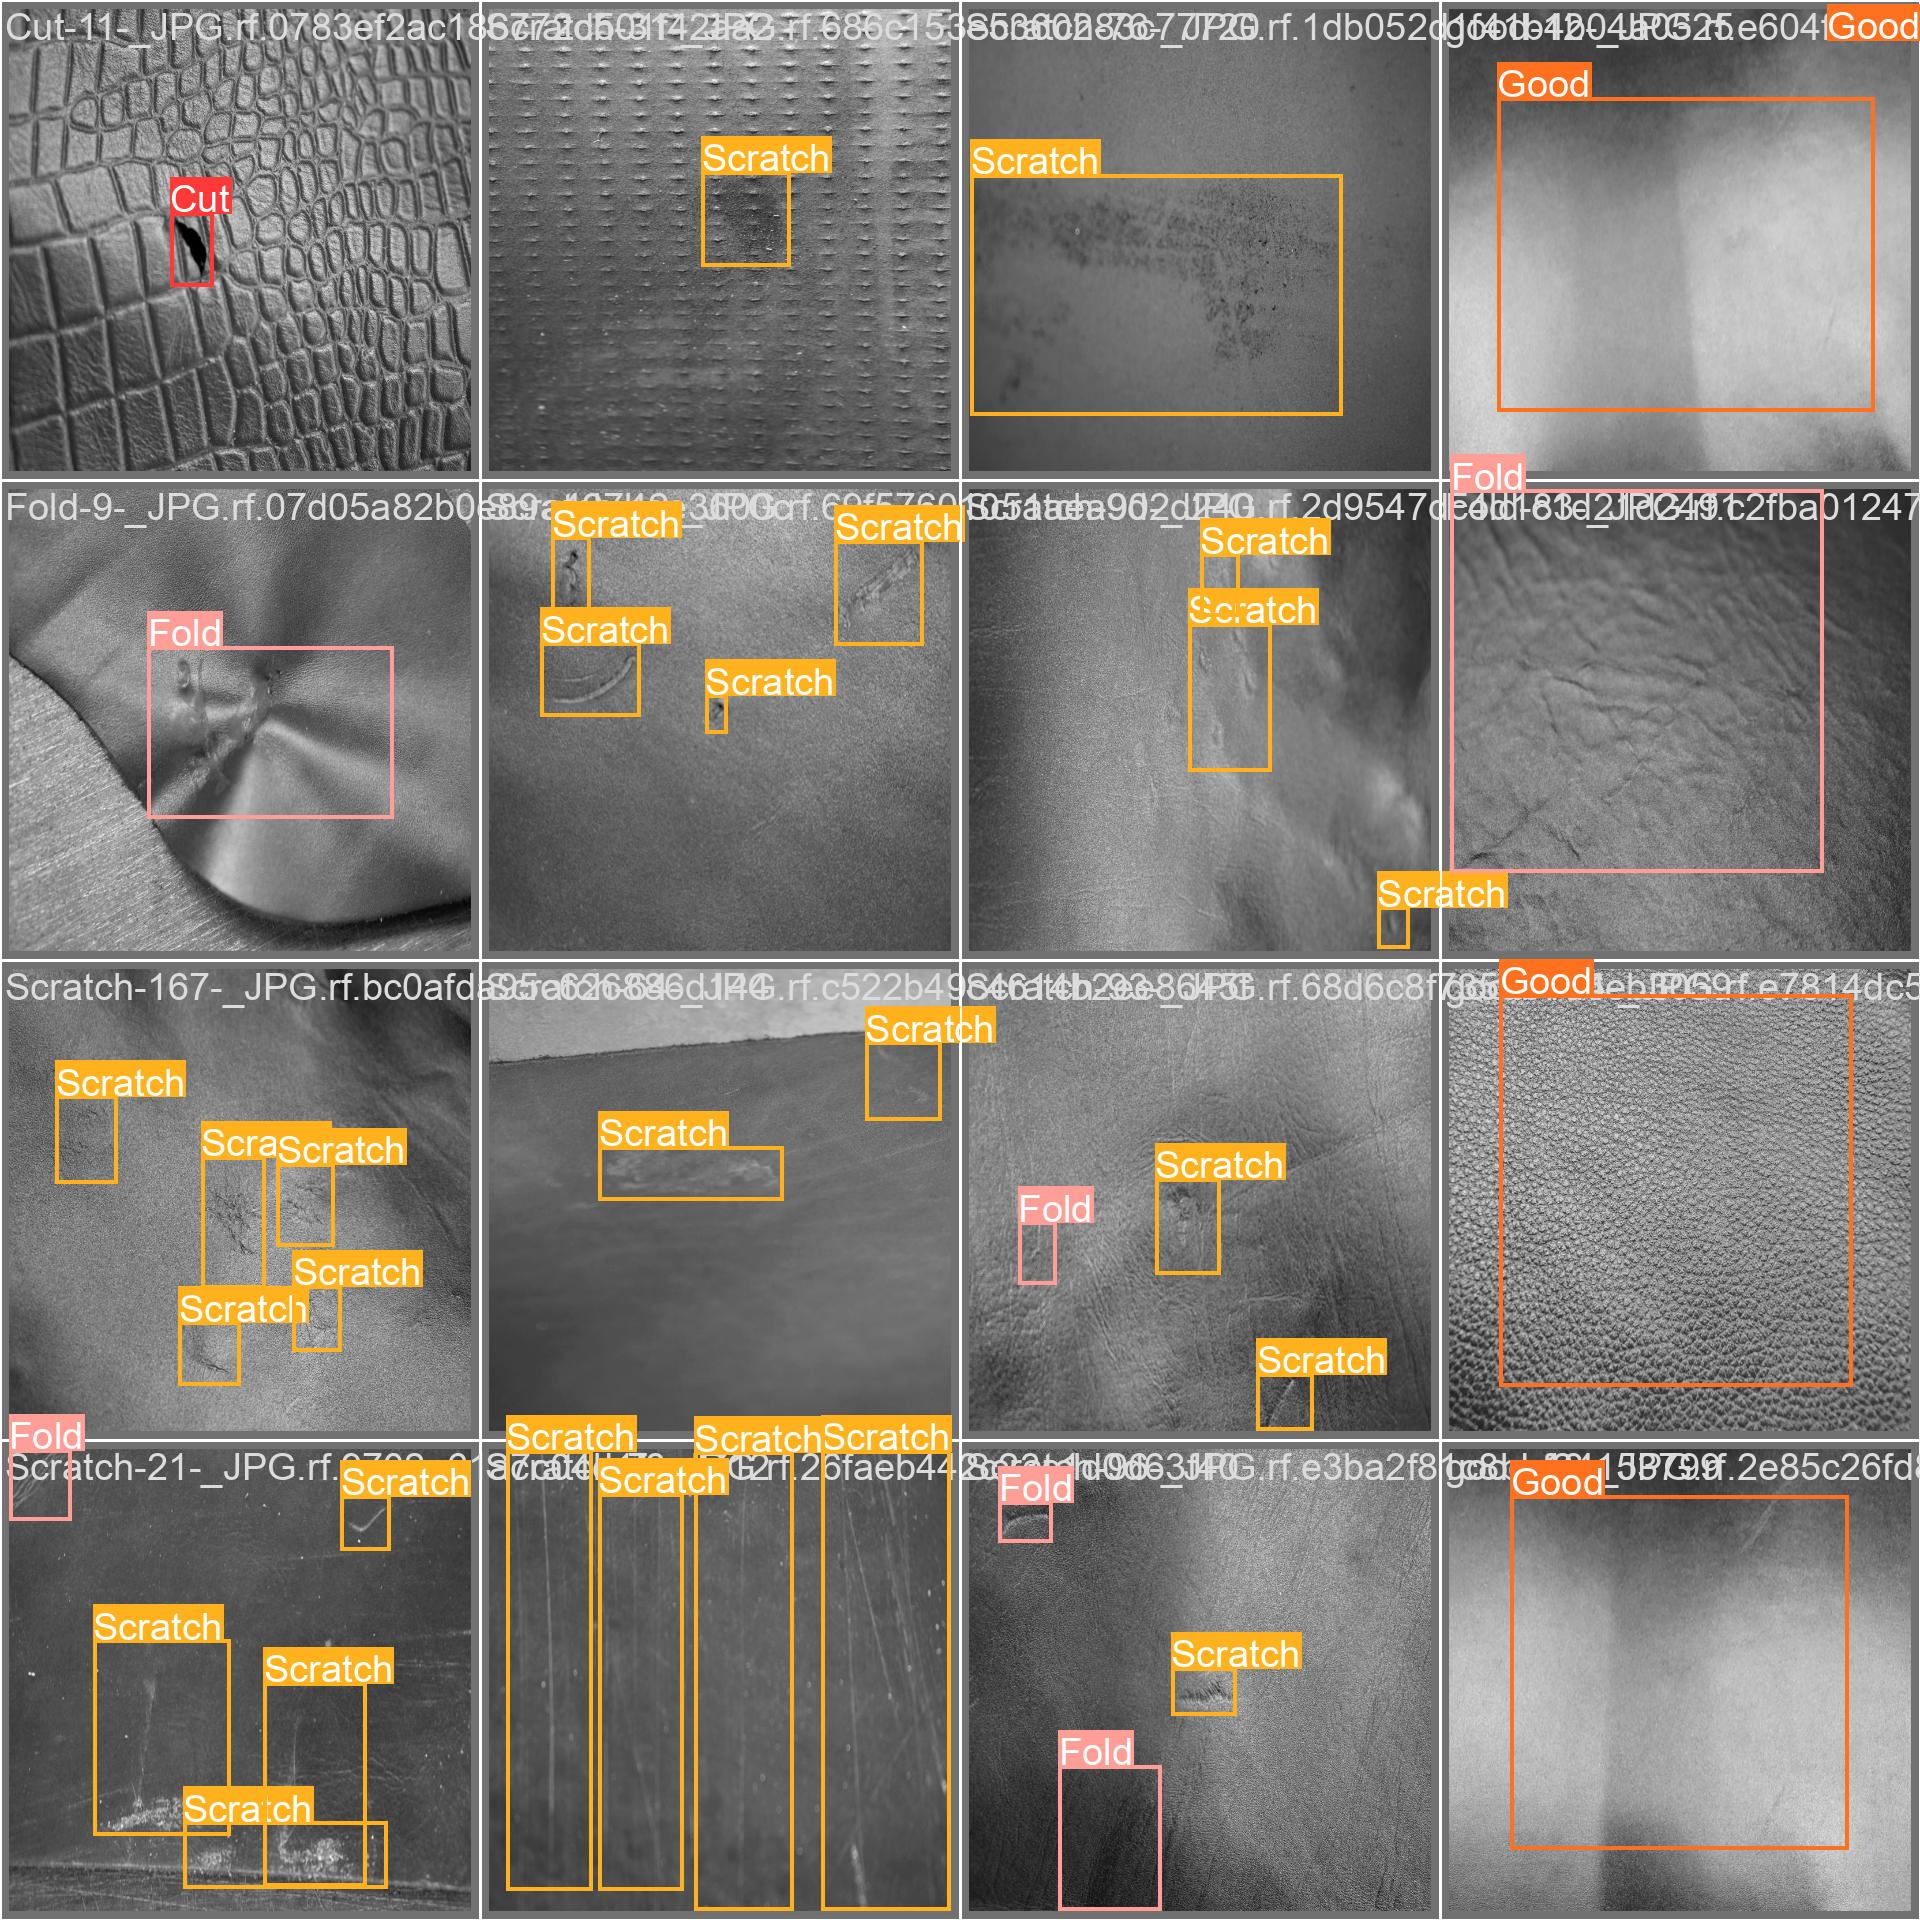

In [16]:
# print out an augmented training example
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

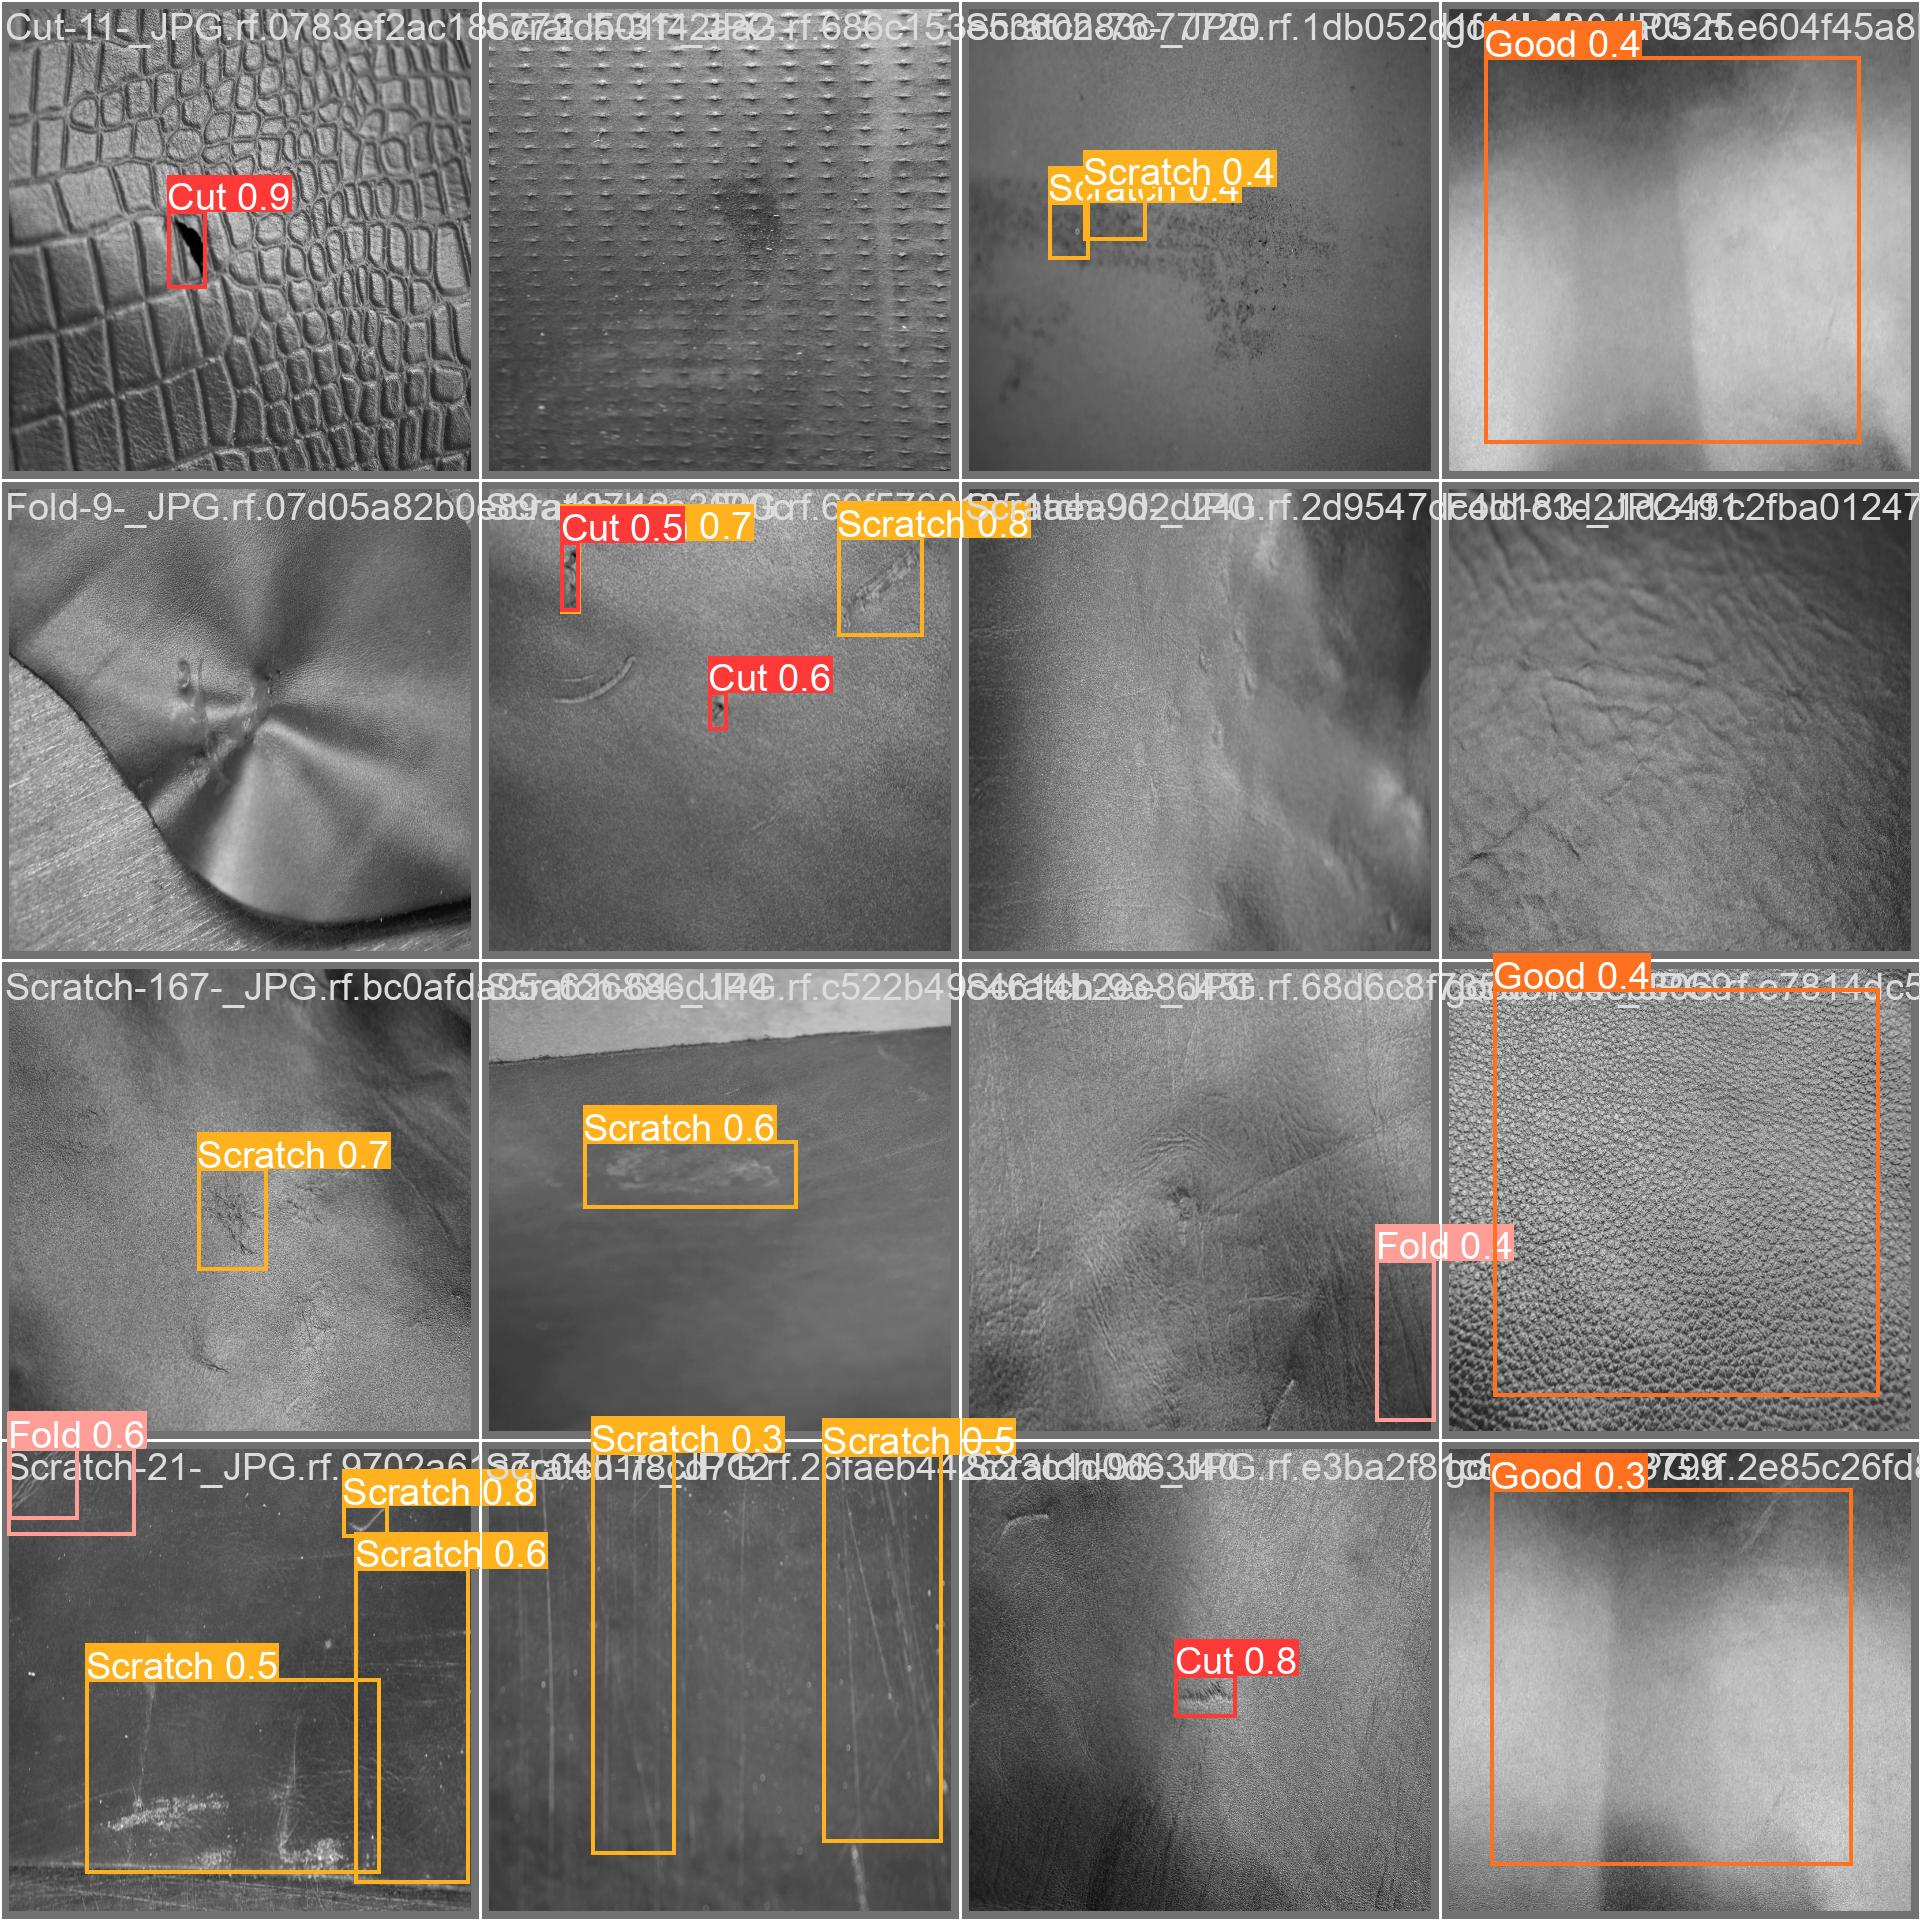

In [17]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_pred.jpg', width=900)

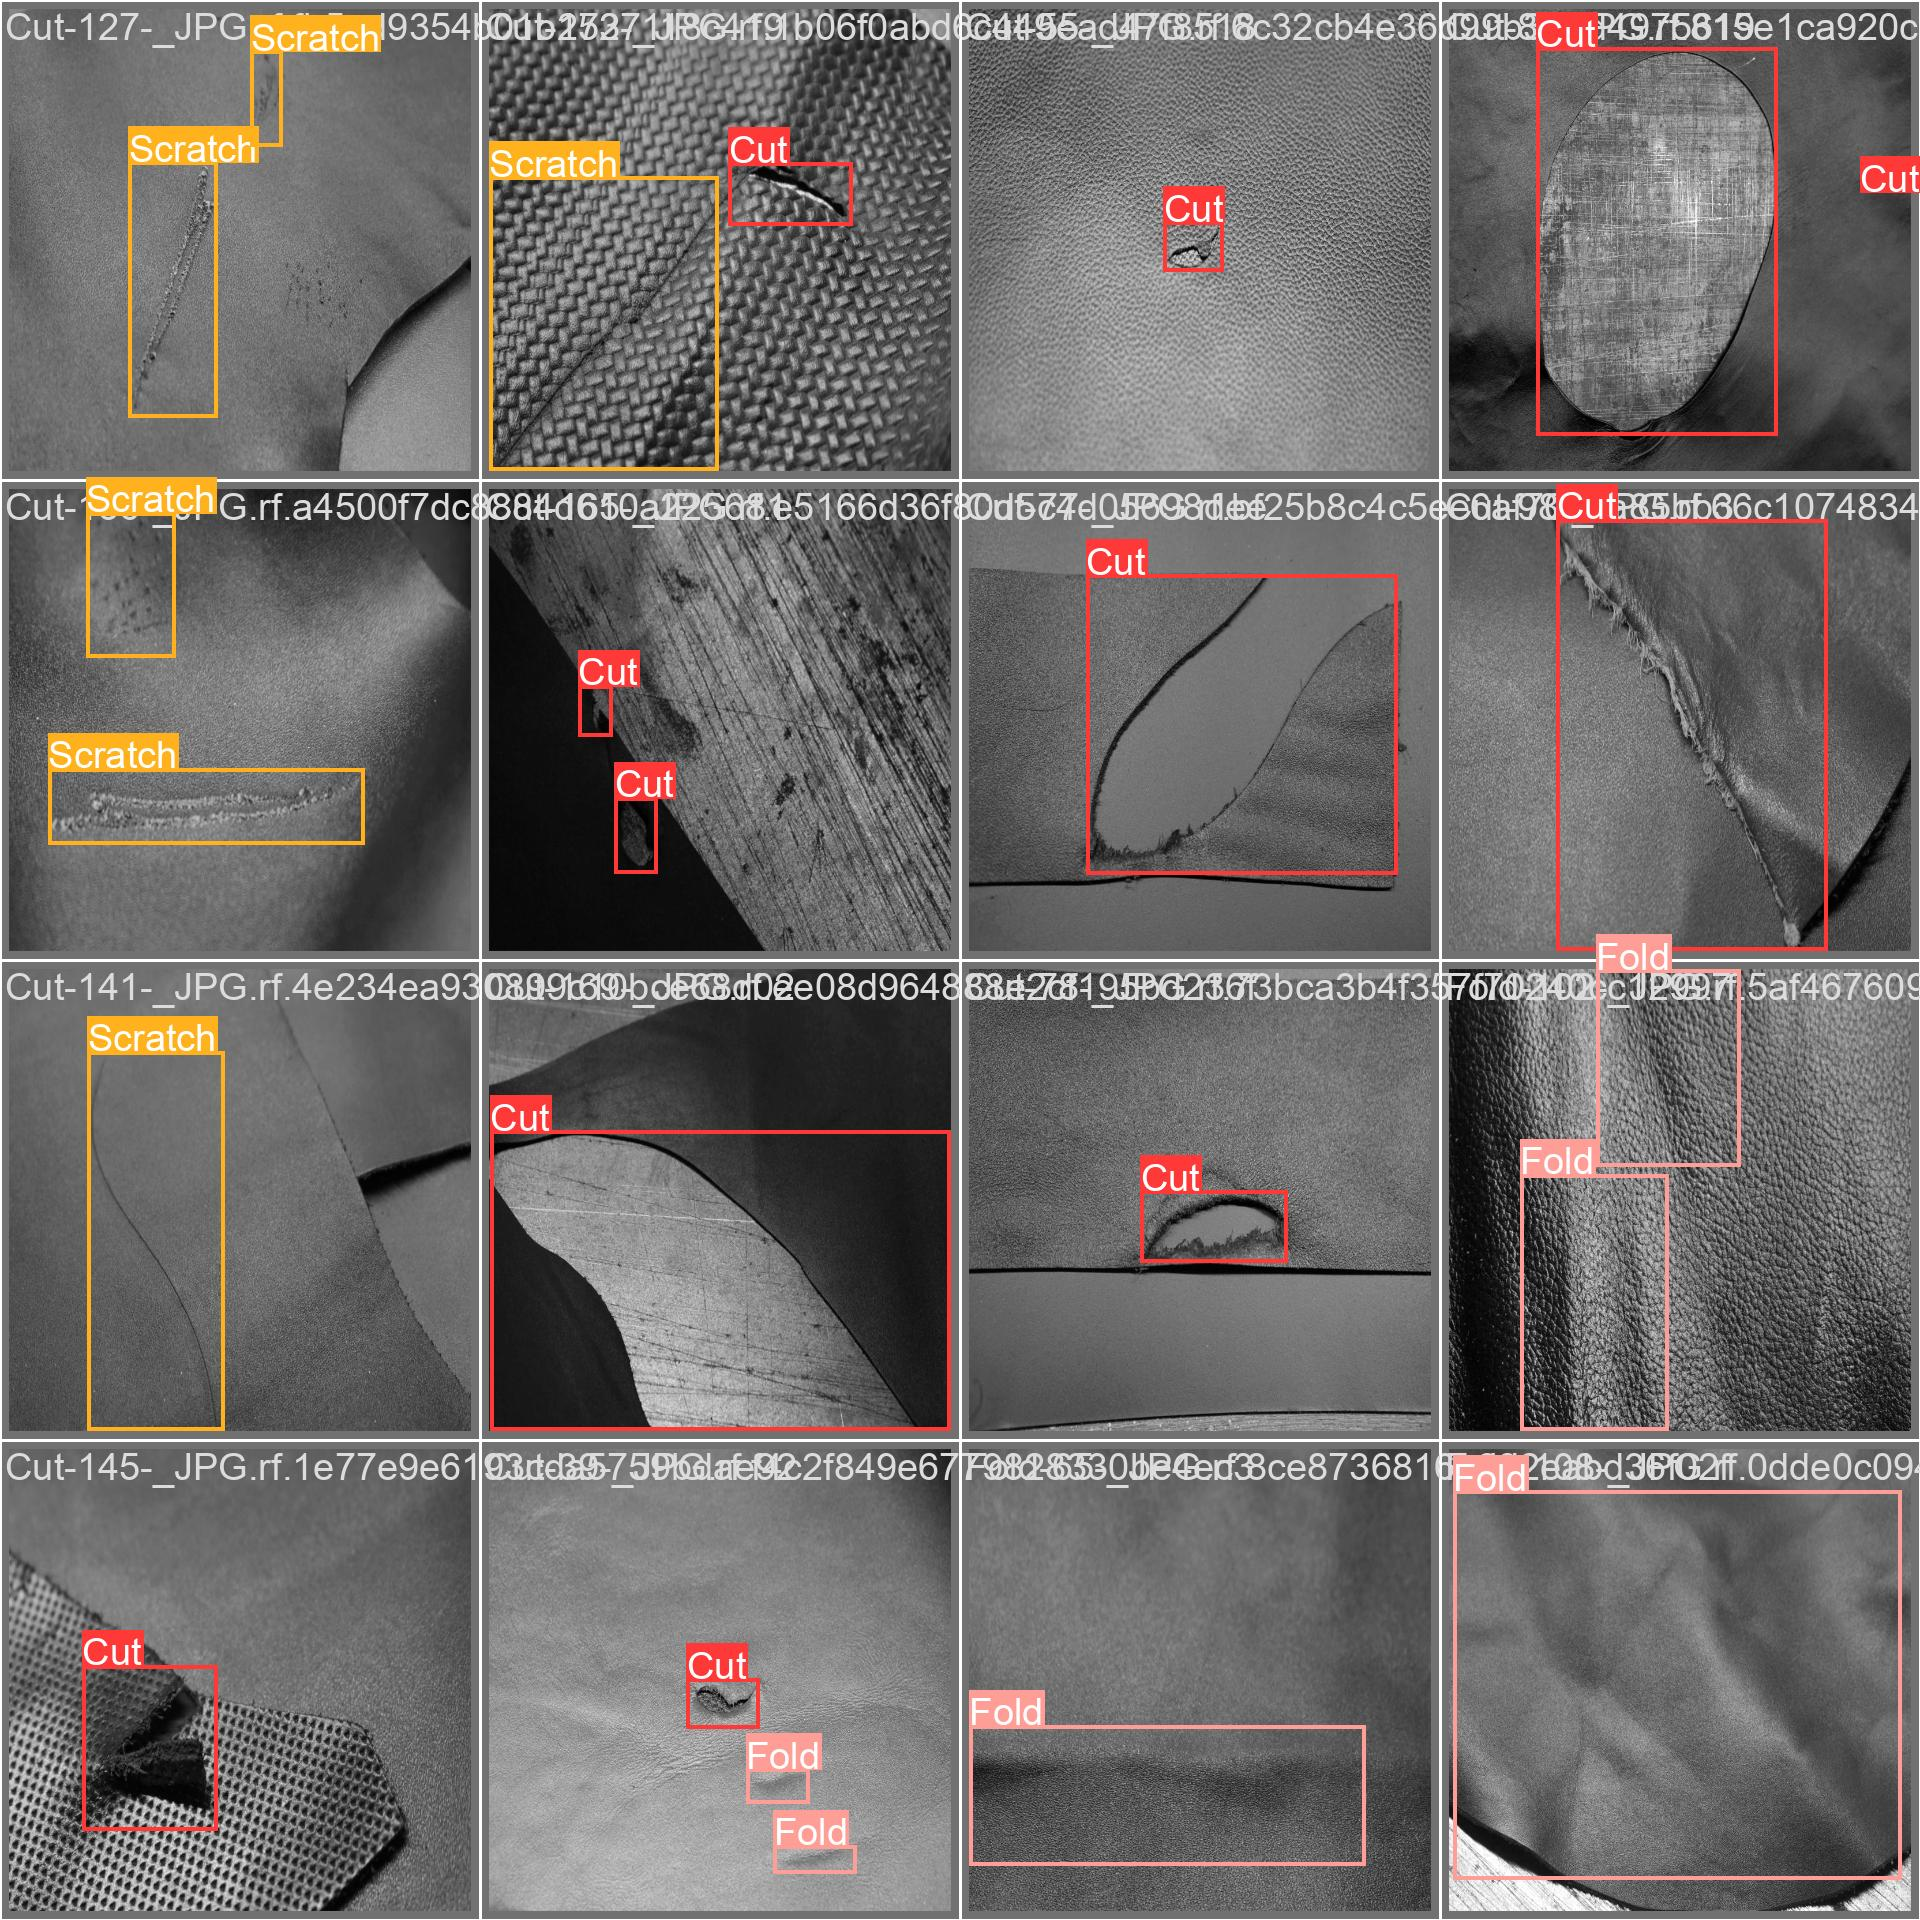

In [18]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch1_labels.jpg', width=900)

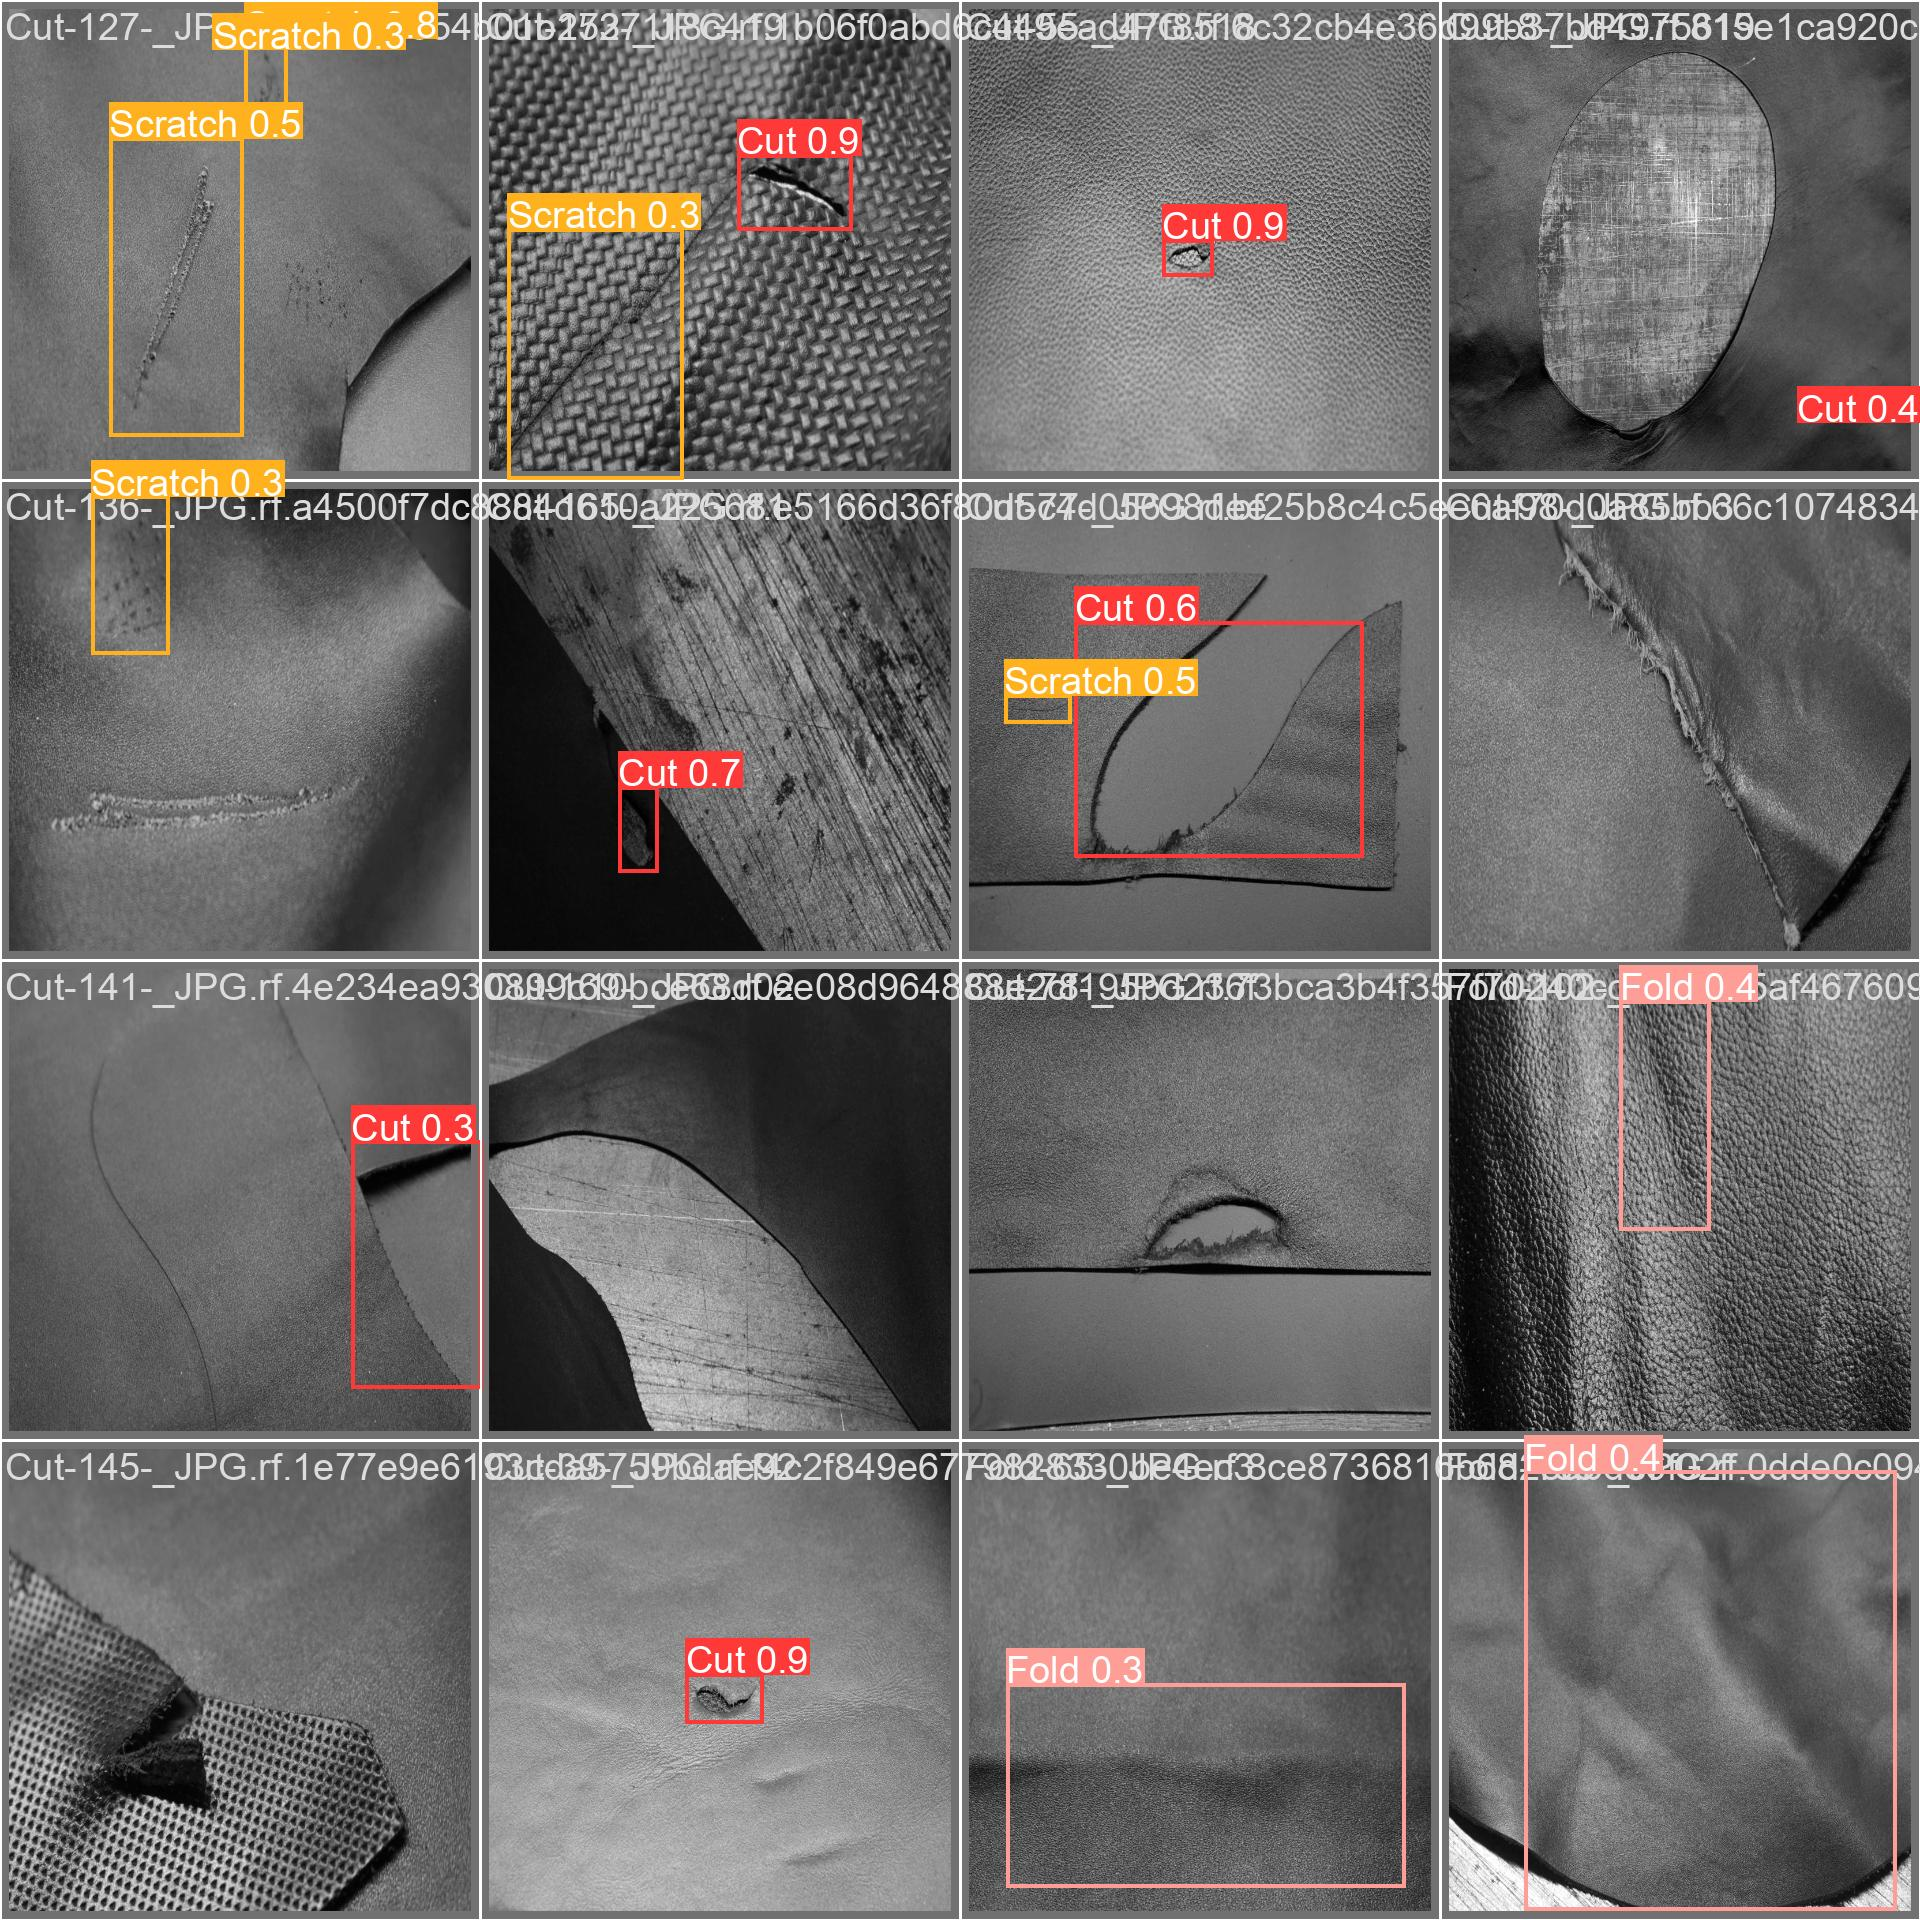

In [19]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch1_pred.jpg', width=900)

In [20]:
!python detect.py --img 800 --weights $WEIGHTS_BEST --conf 0.5 --source '/content/yolov5/Leather-Defect-Detection-5/test/images'

detect: weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'], source=/content/yolov5/Leather-Defect-Detection-5/test/images, data=data/coco128.yaml, imgsz=[800, 800], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-368-gb163ff8d Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7254609 parameters, 0 gradients
image 1/93 /content/yolov5/Leather-Defect-Detection-5/test/images/Cut-126-_JPG.rf.98266f4f5a6c2c1af31705b34cae9875.jpg: 800x800 (no detections), 16.6ms
WARNING ⚠️ NMS time limit 0.550s exceeded
image 2/93 /content/yolov5/Leather-Defect-Detection-5/test/ima

In [21]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

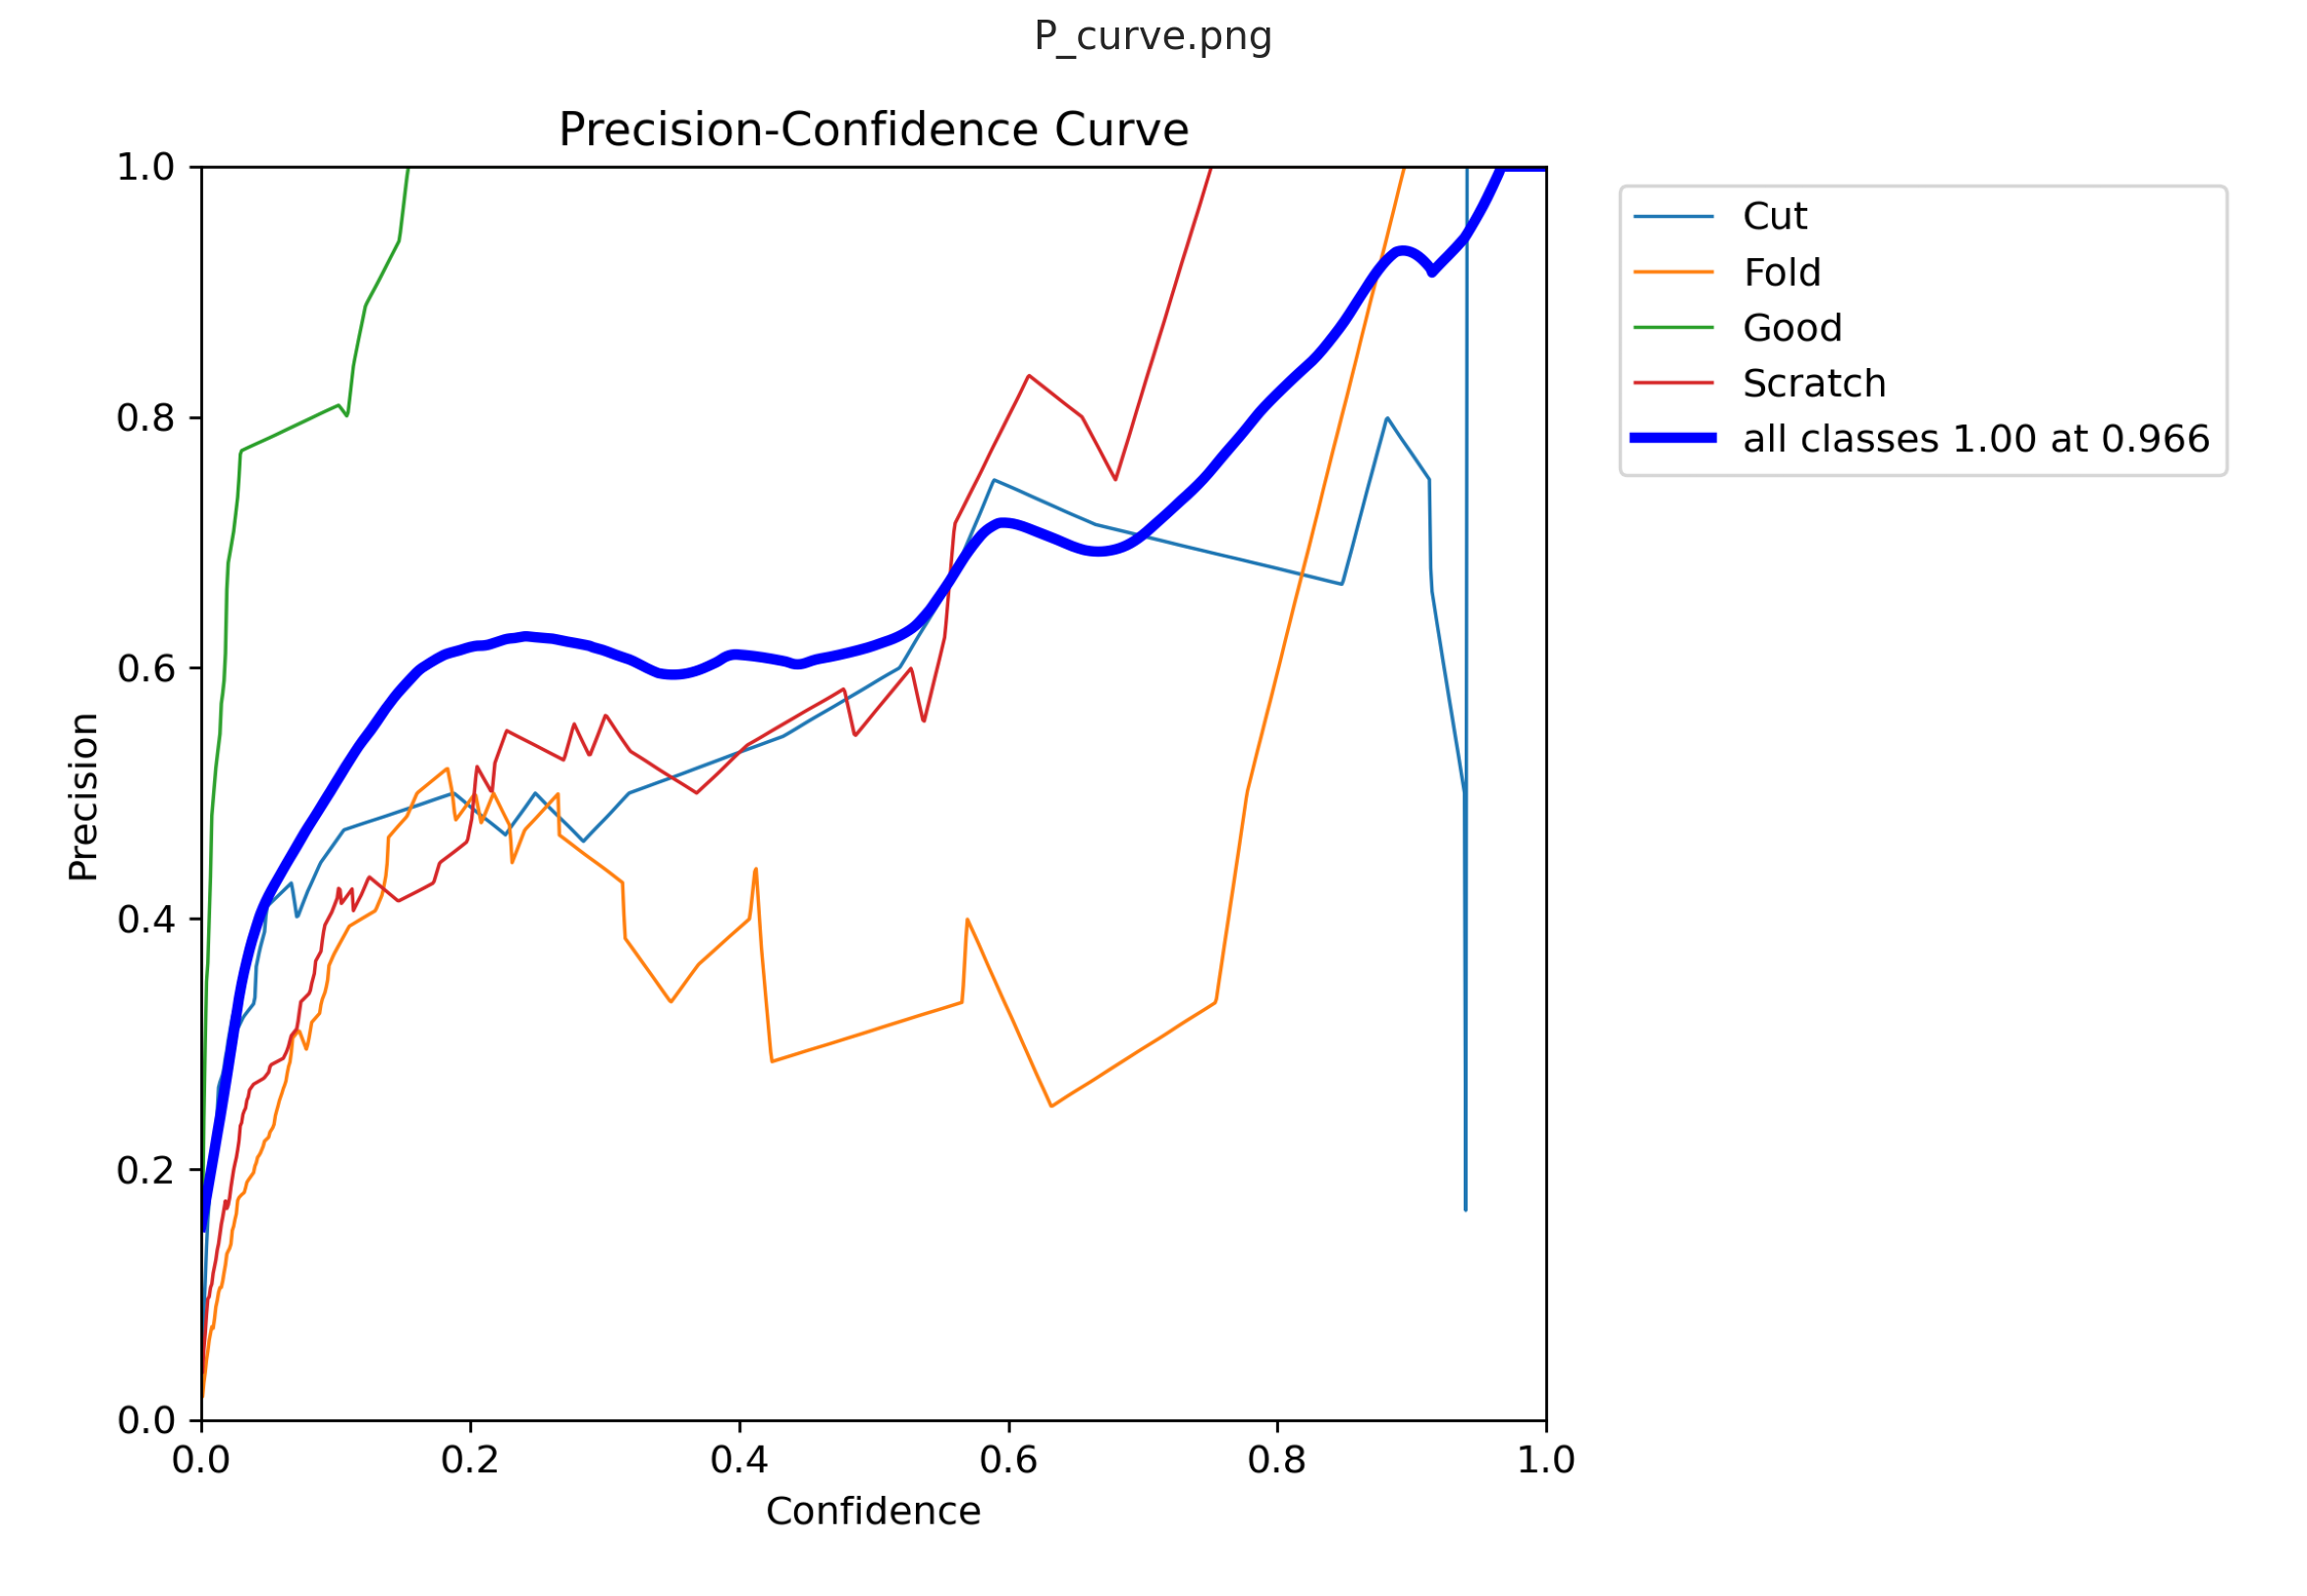

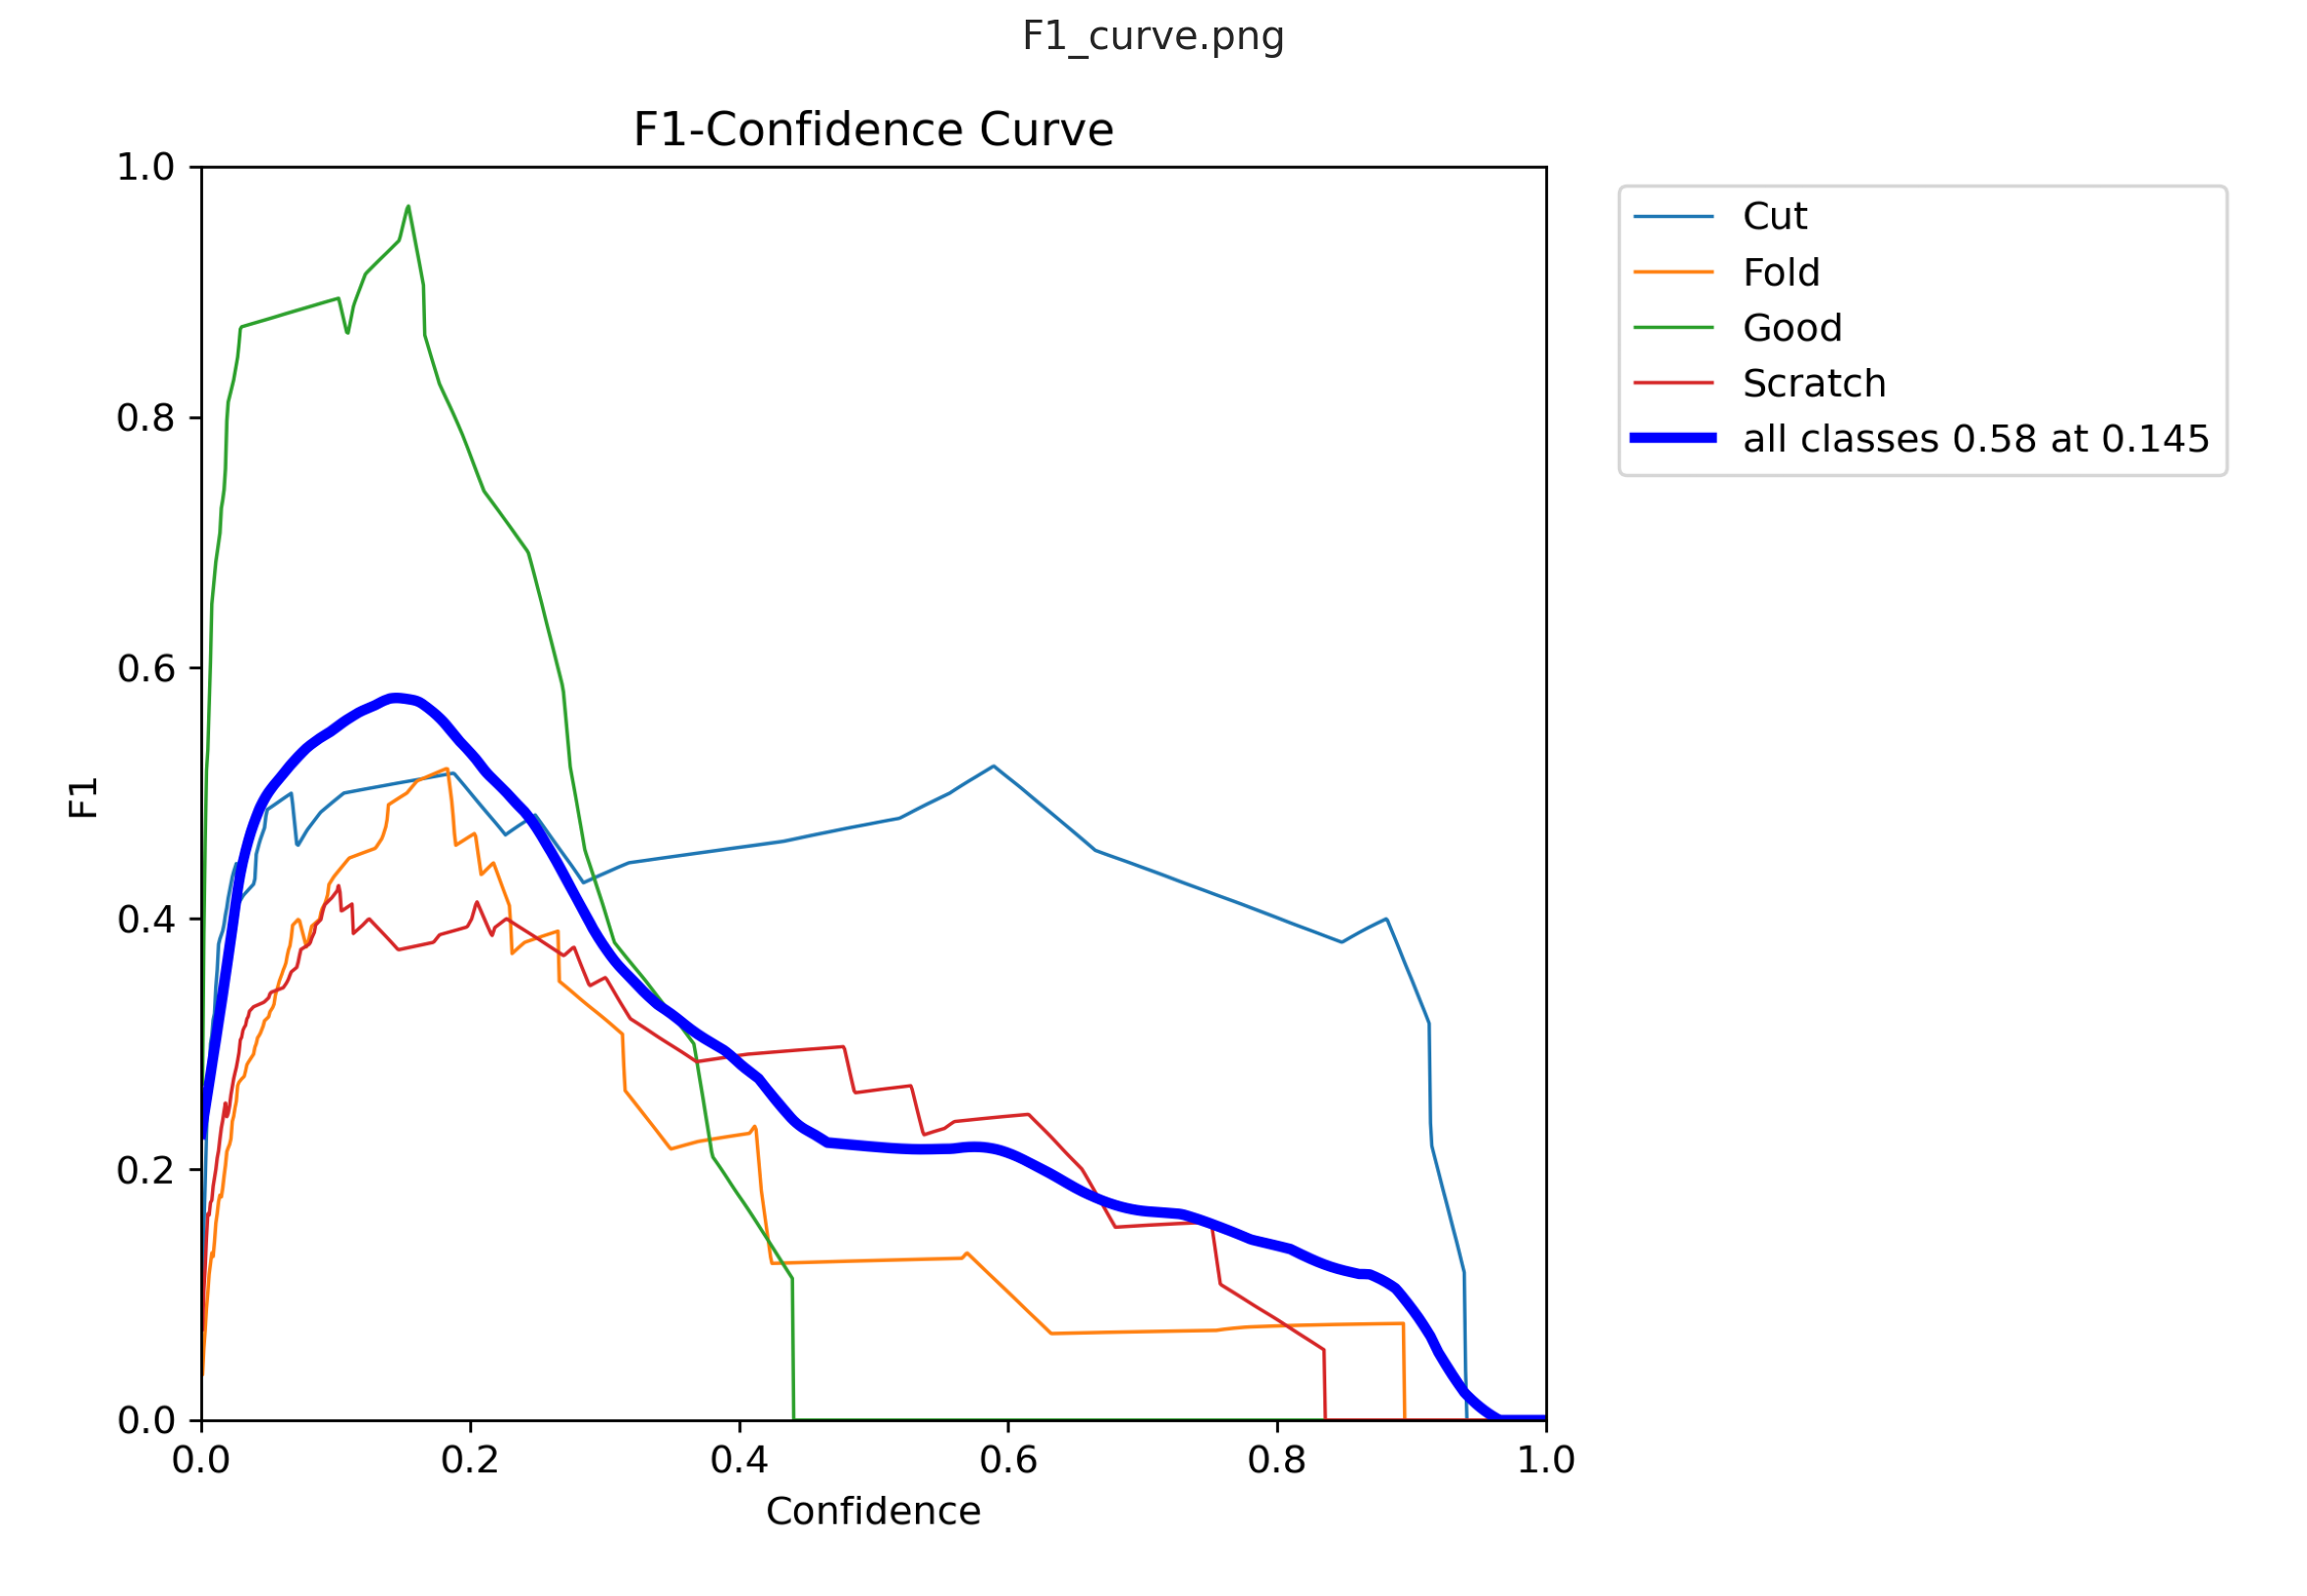

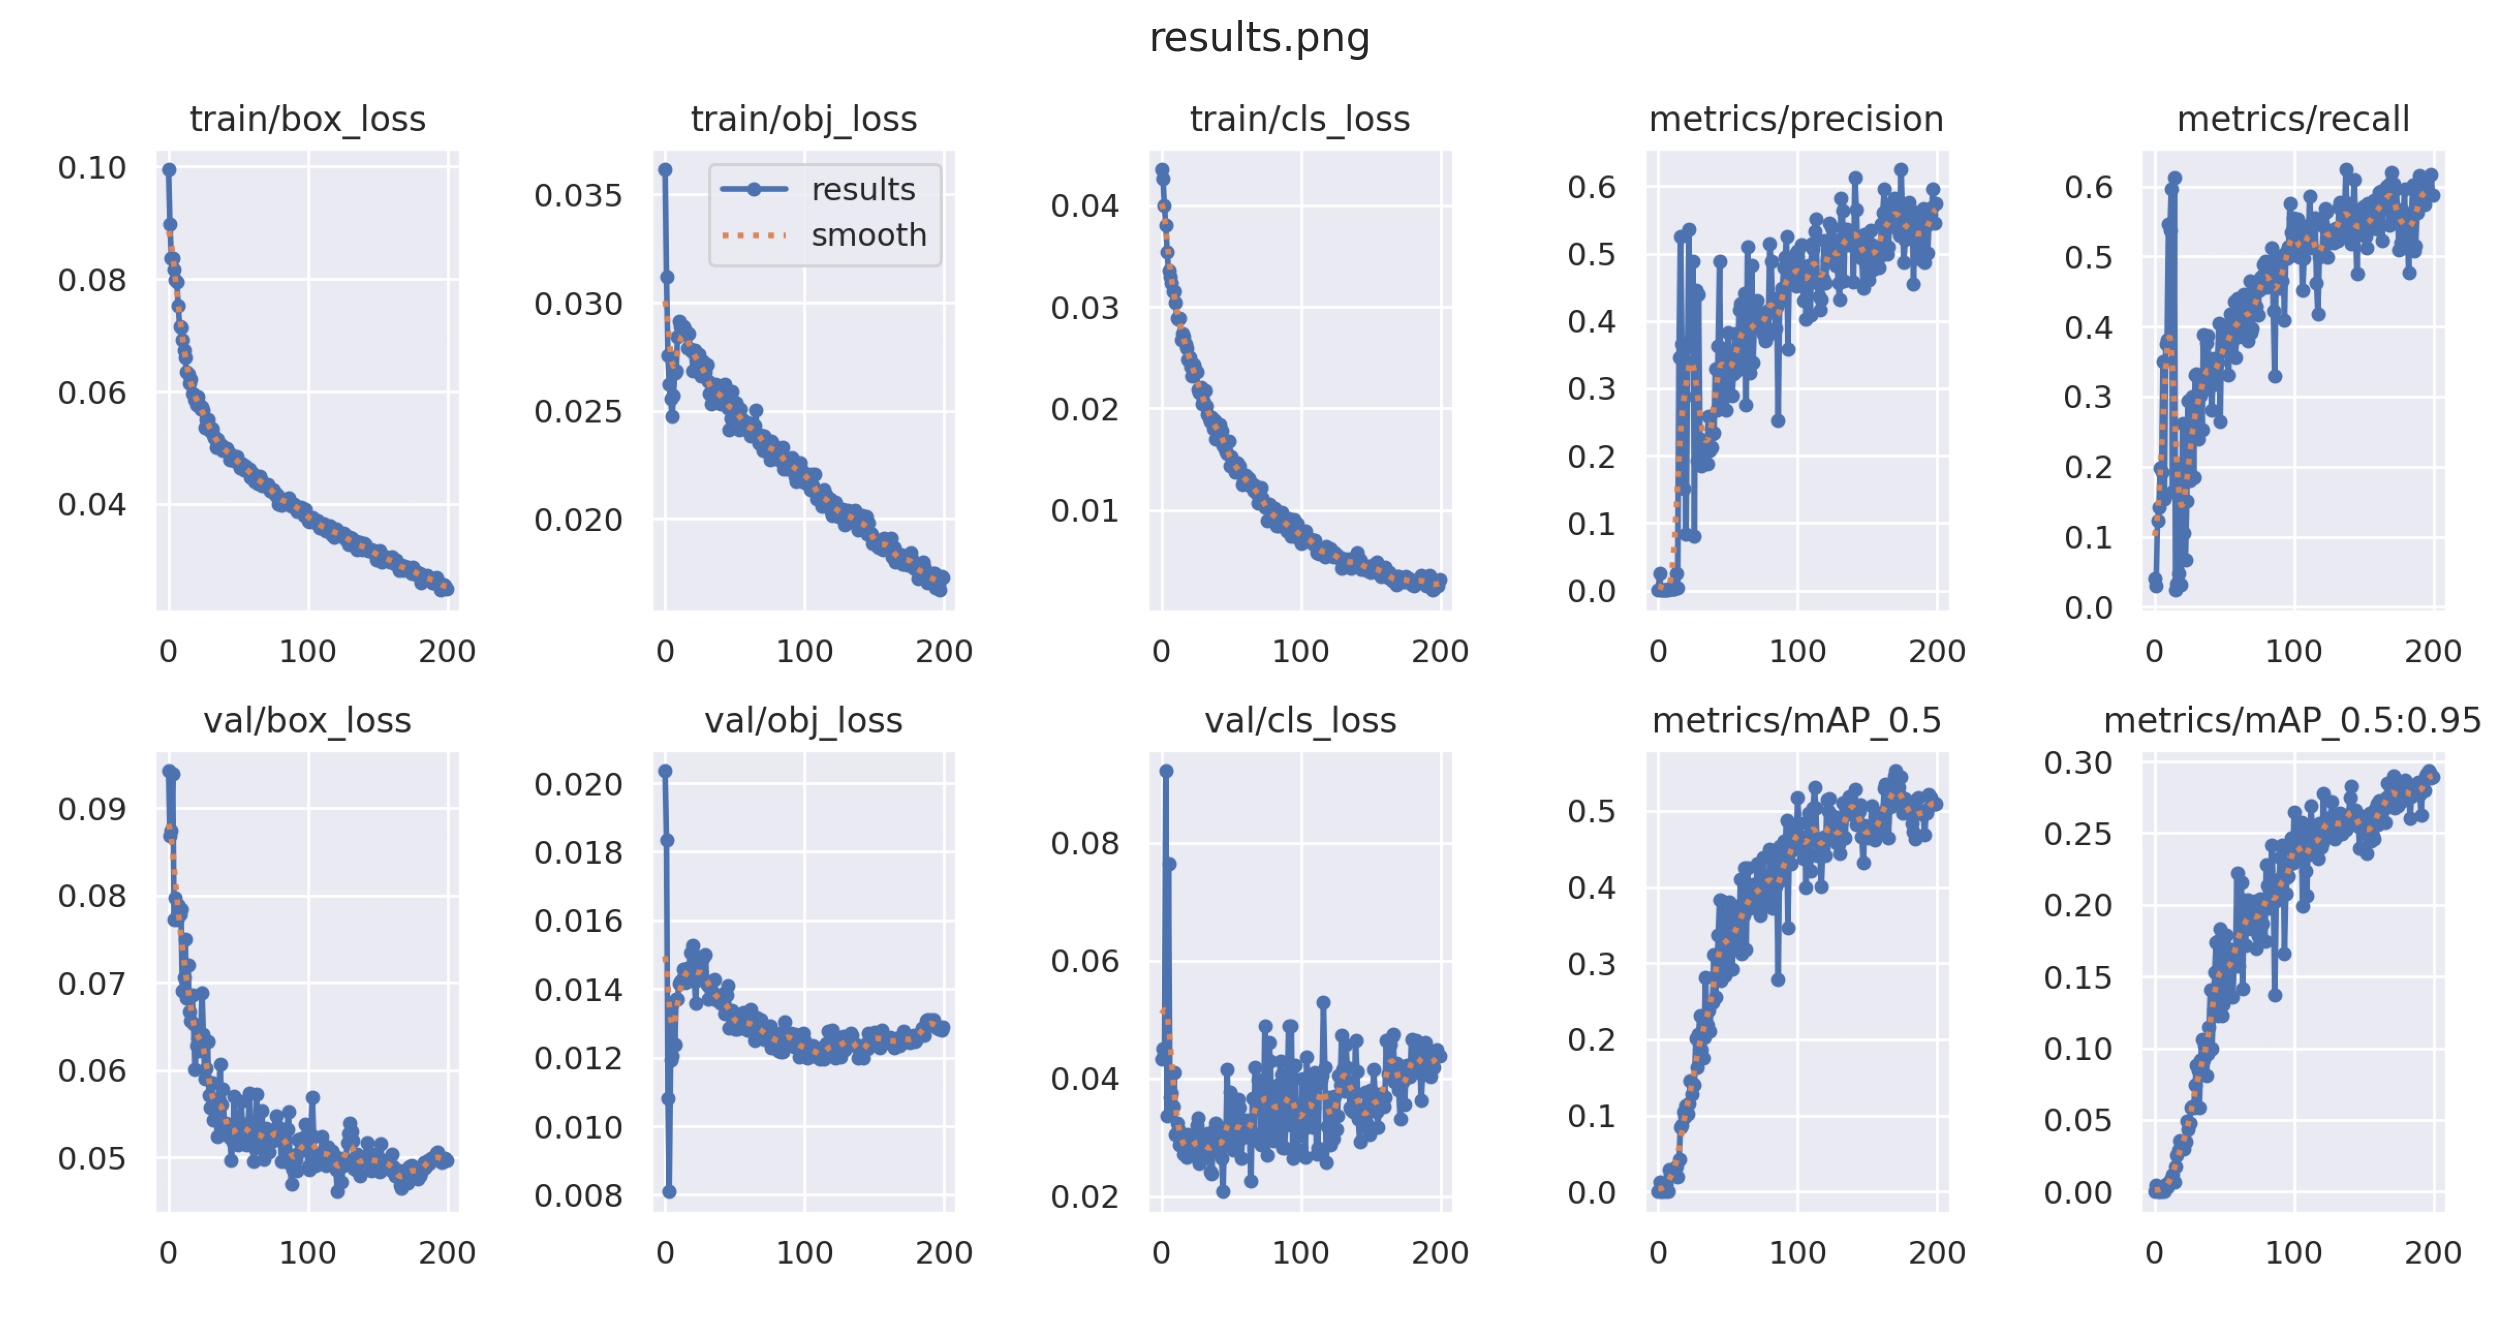

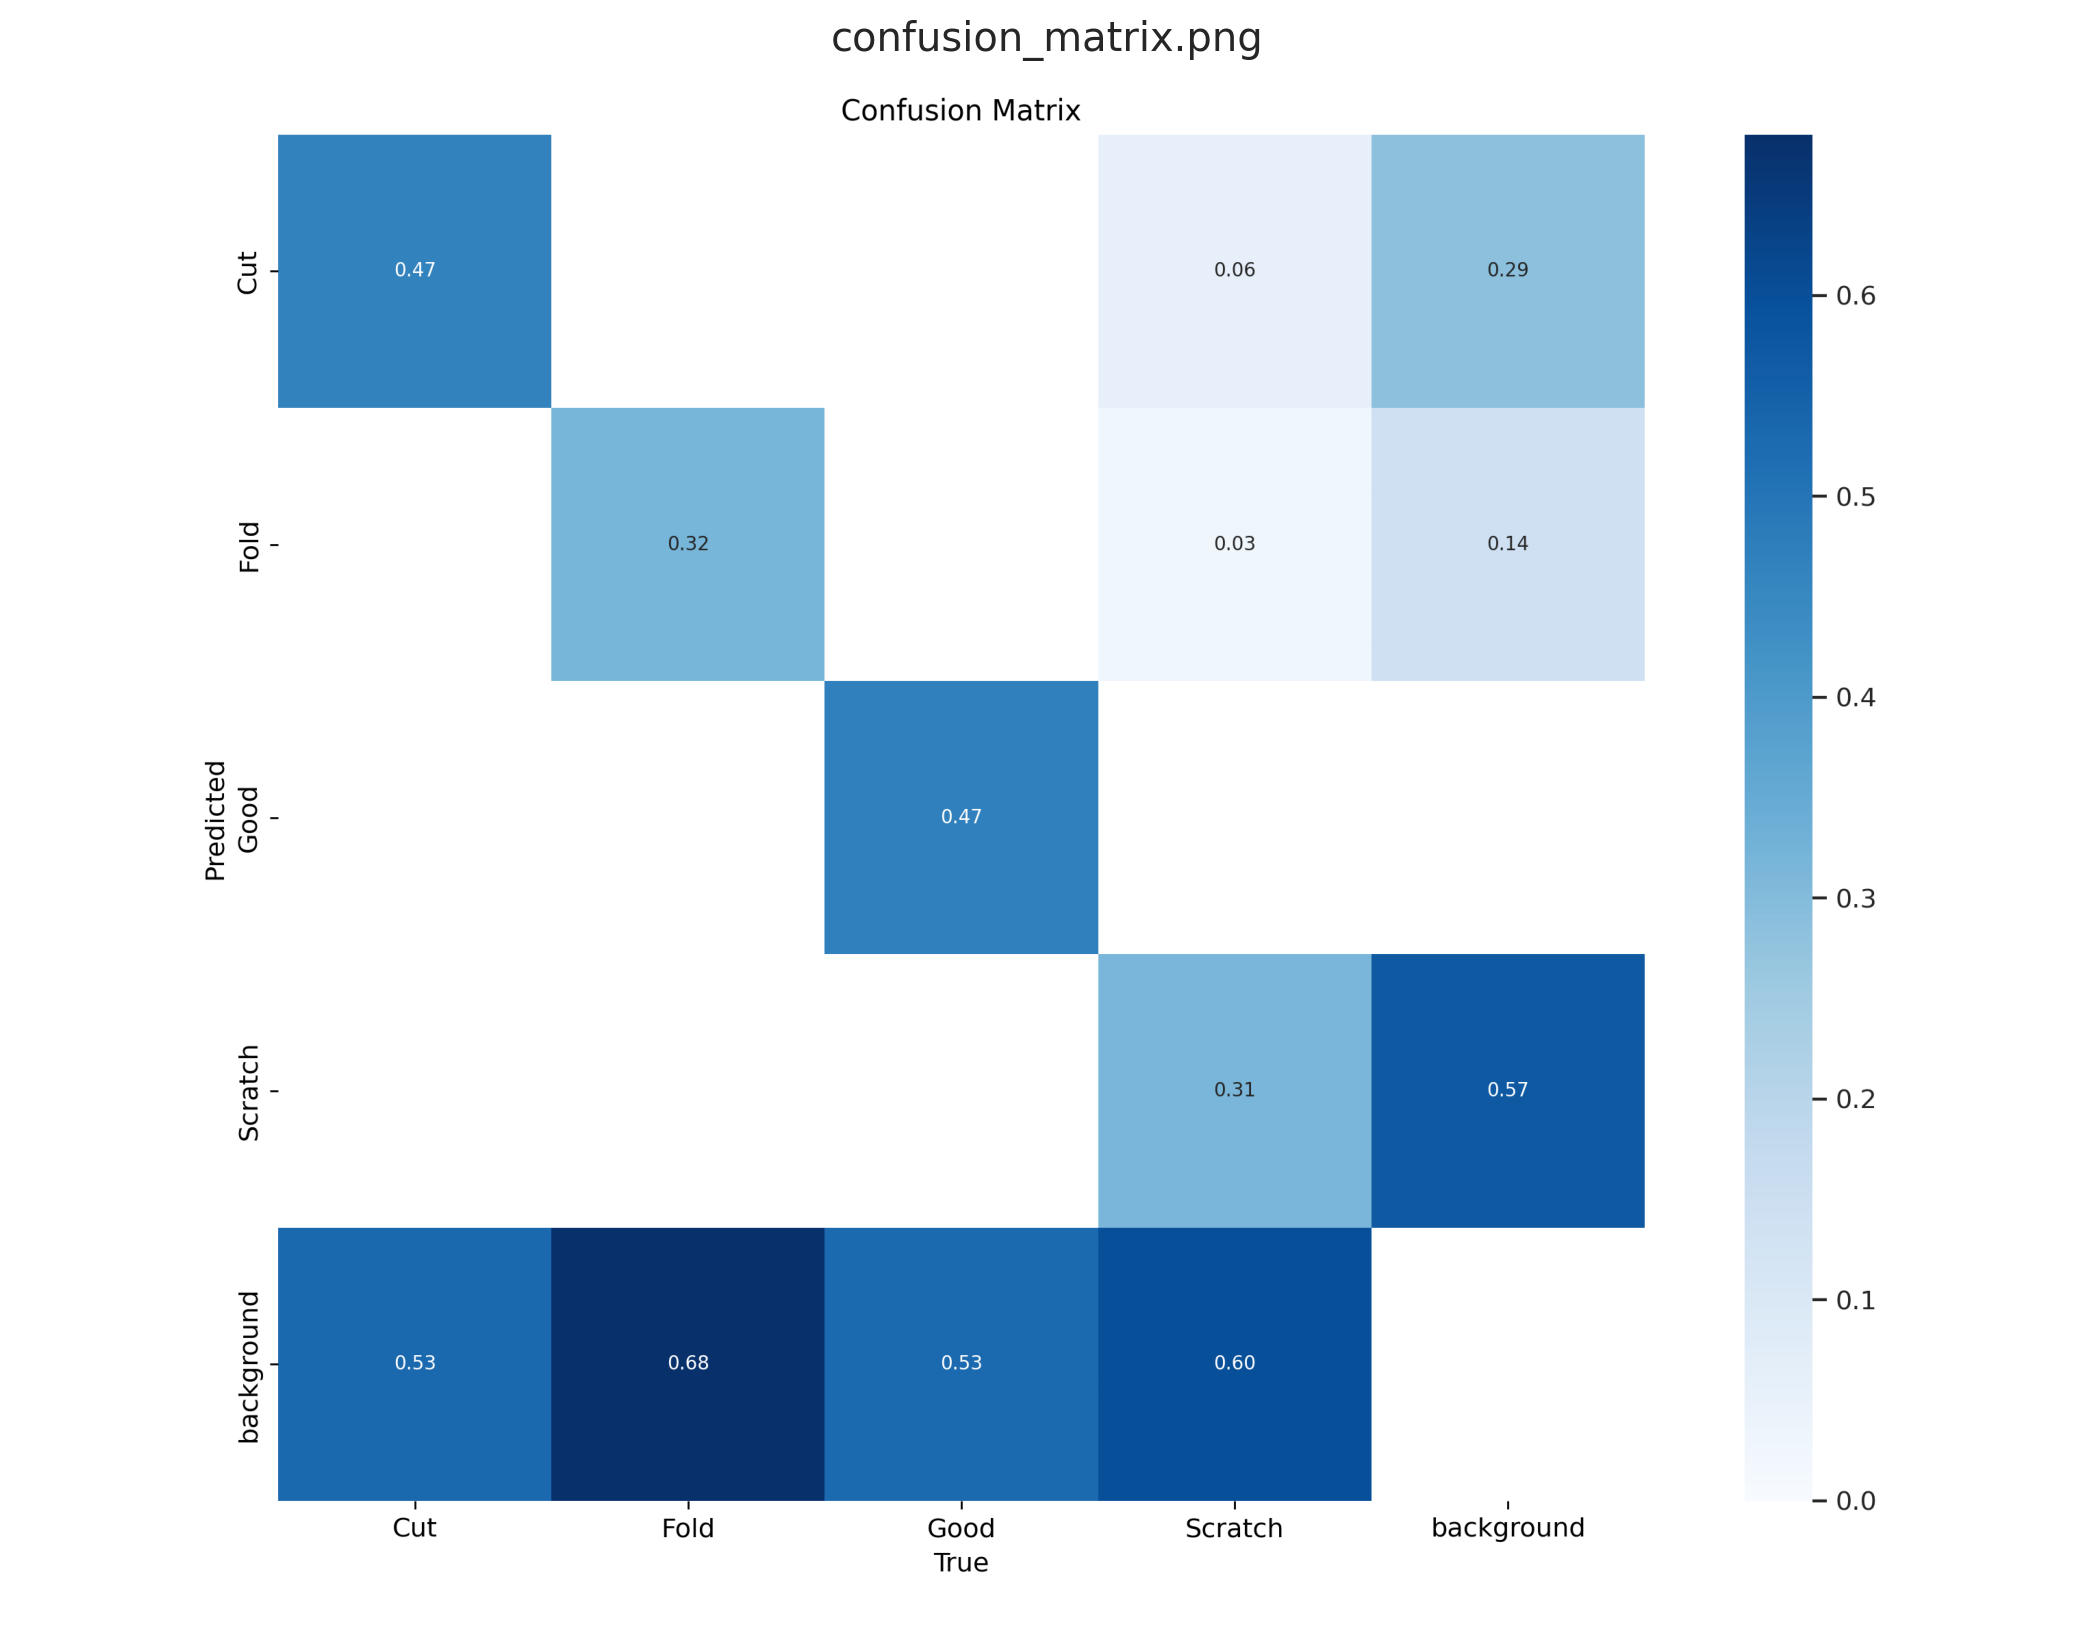

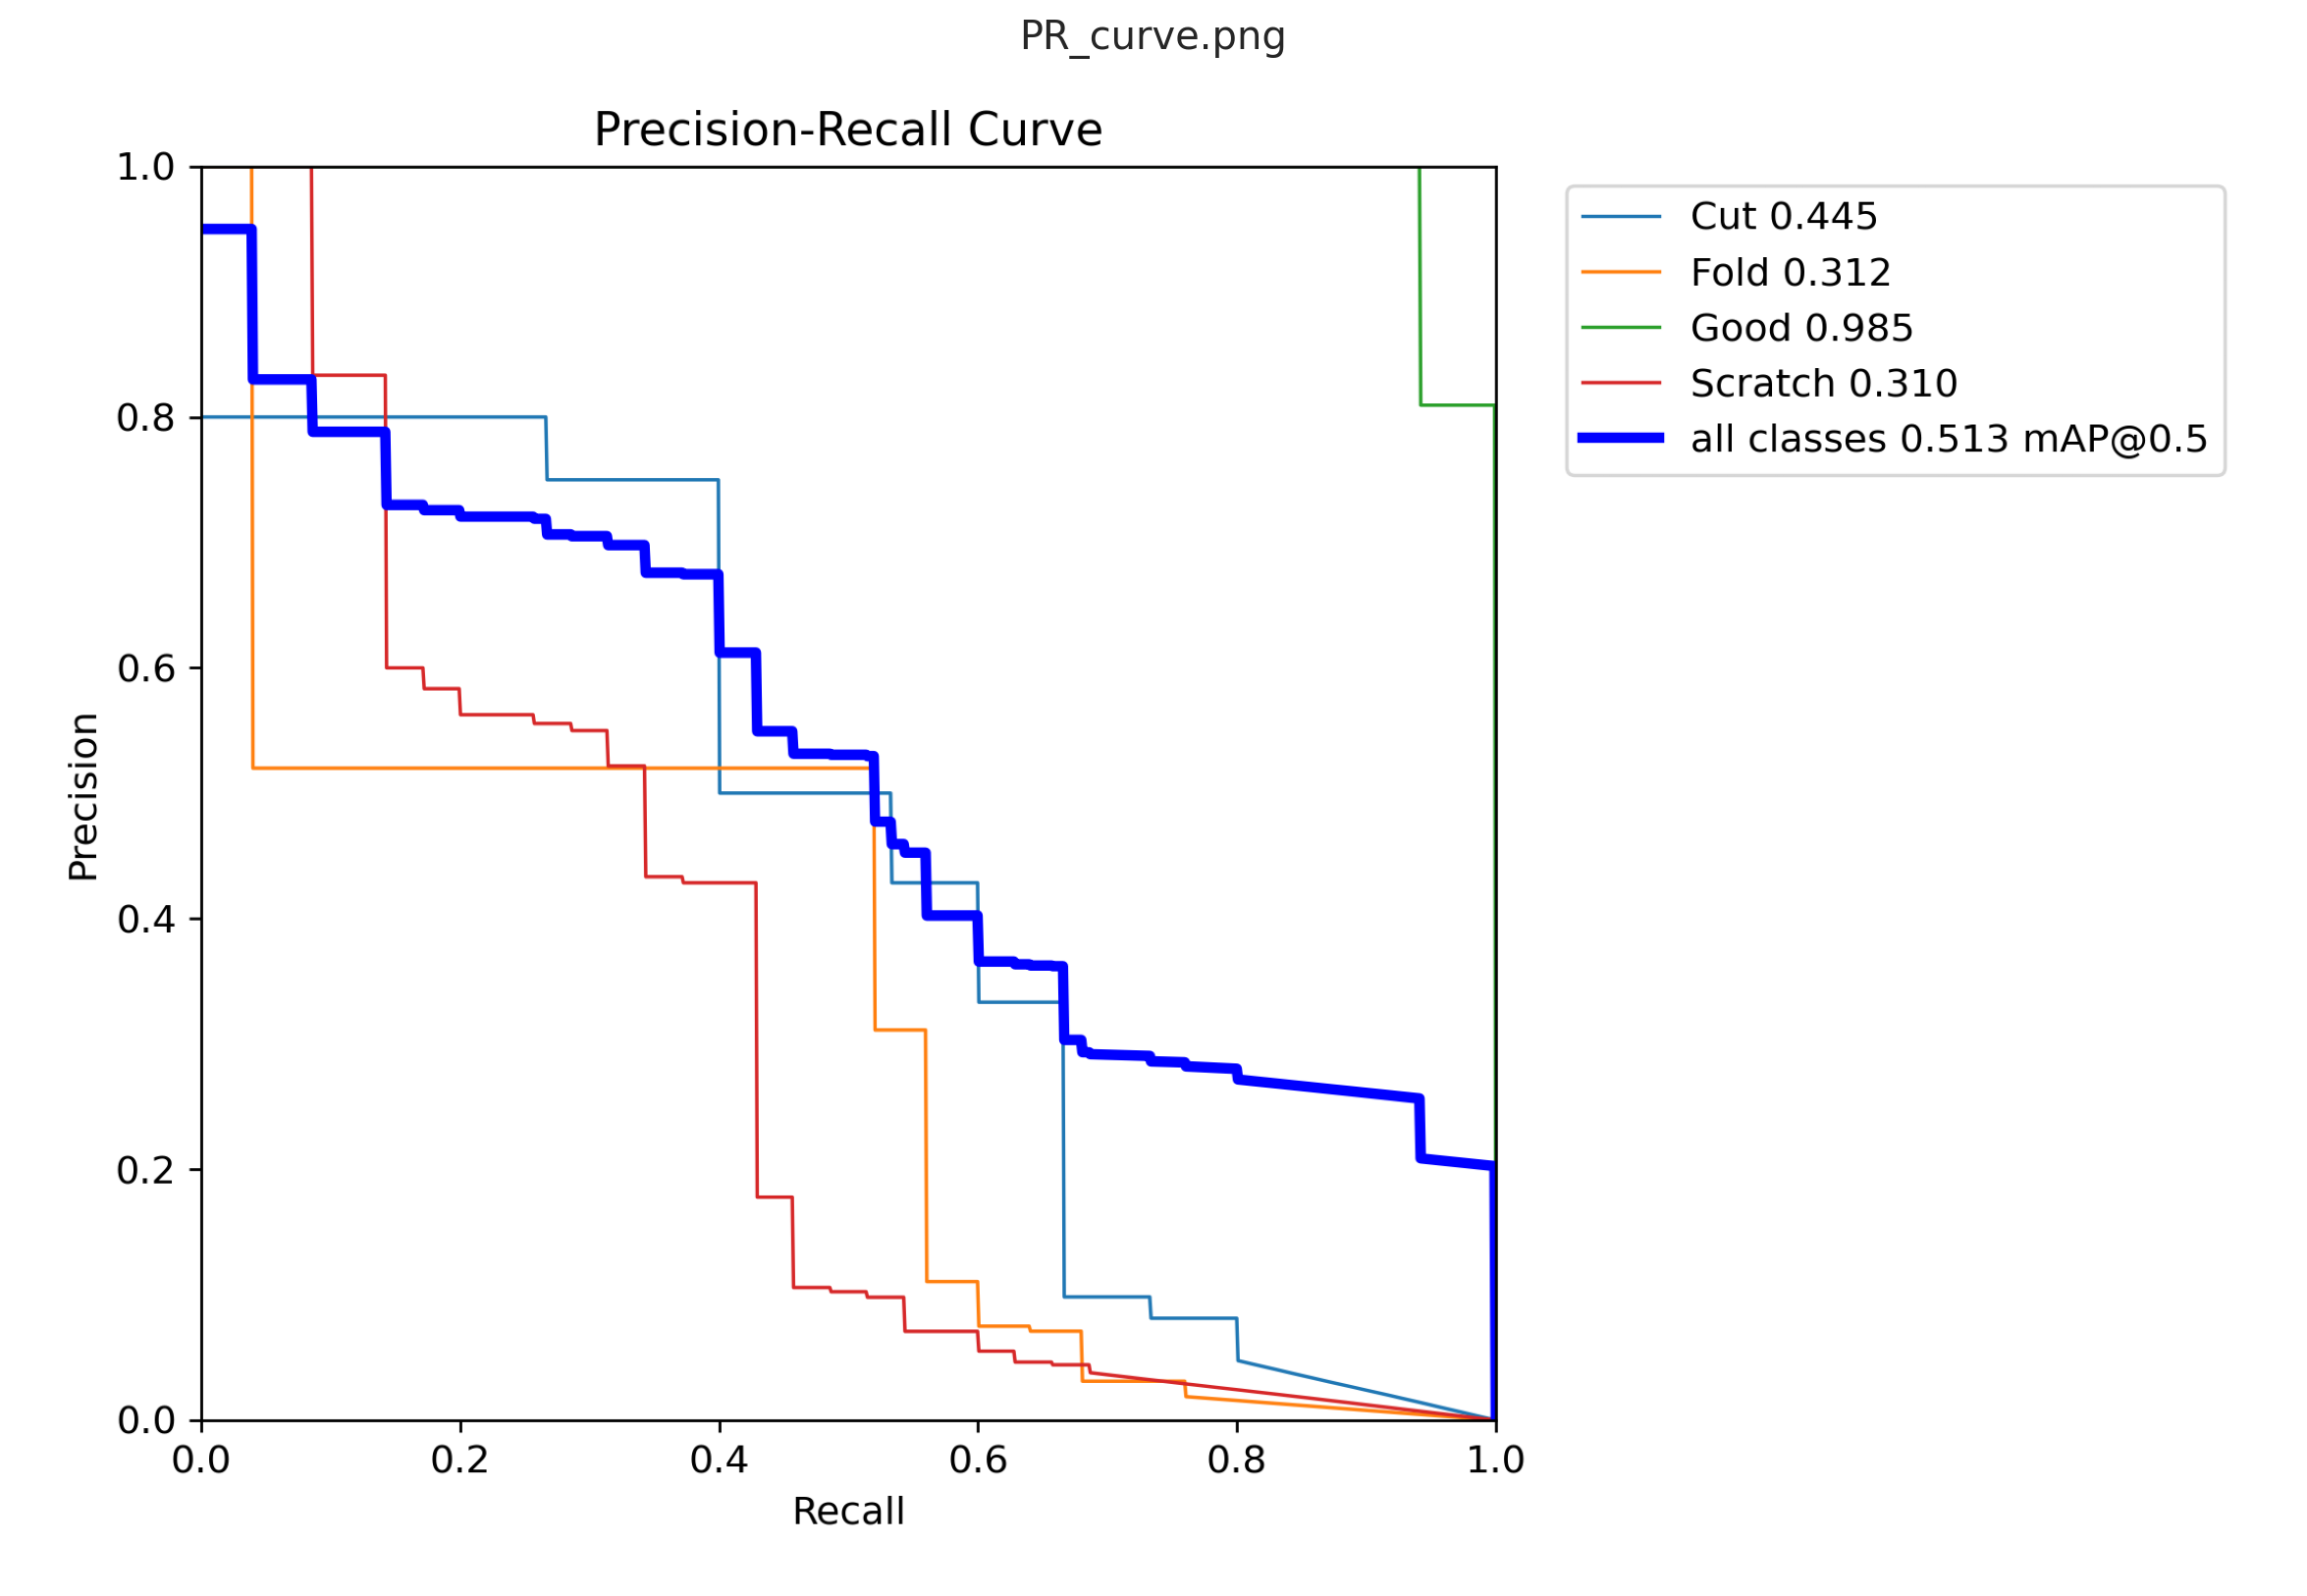

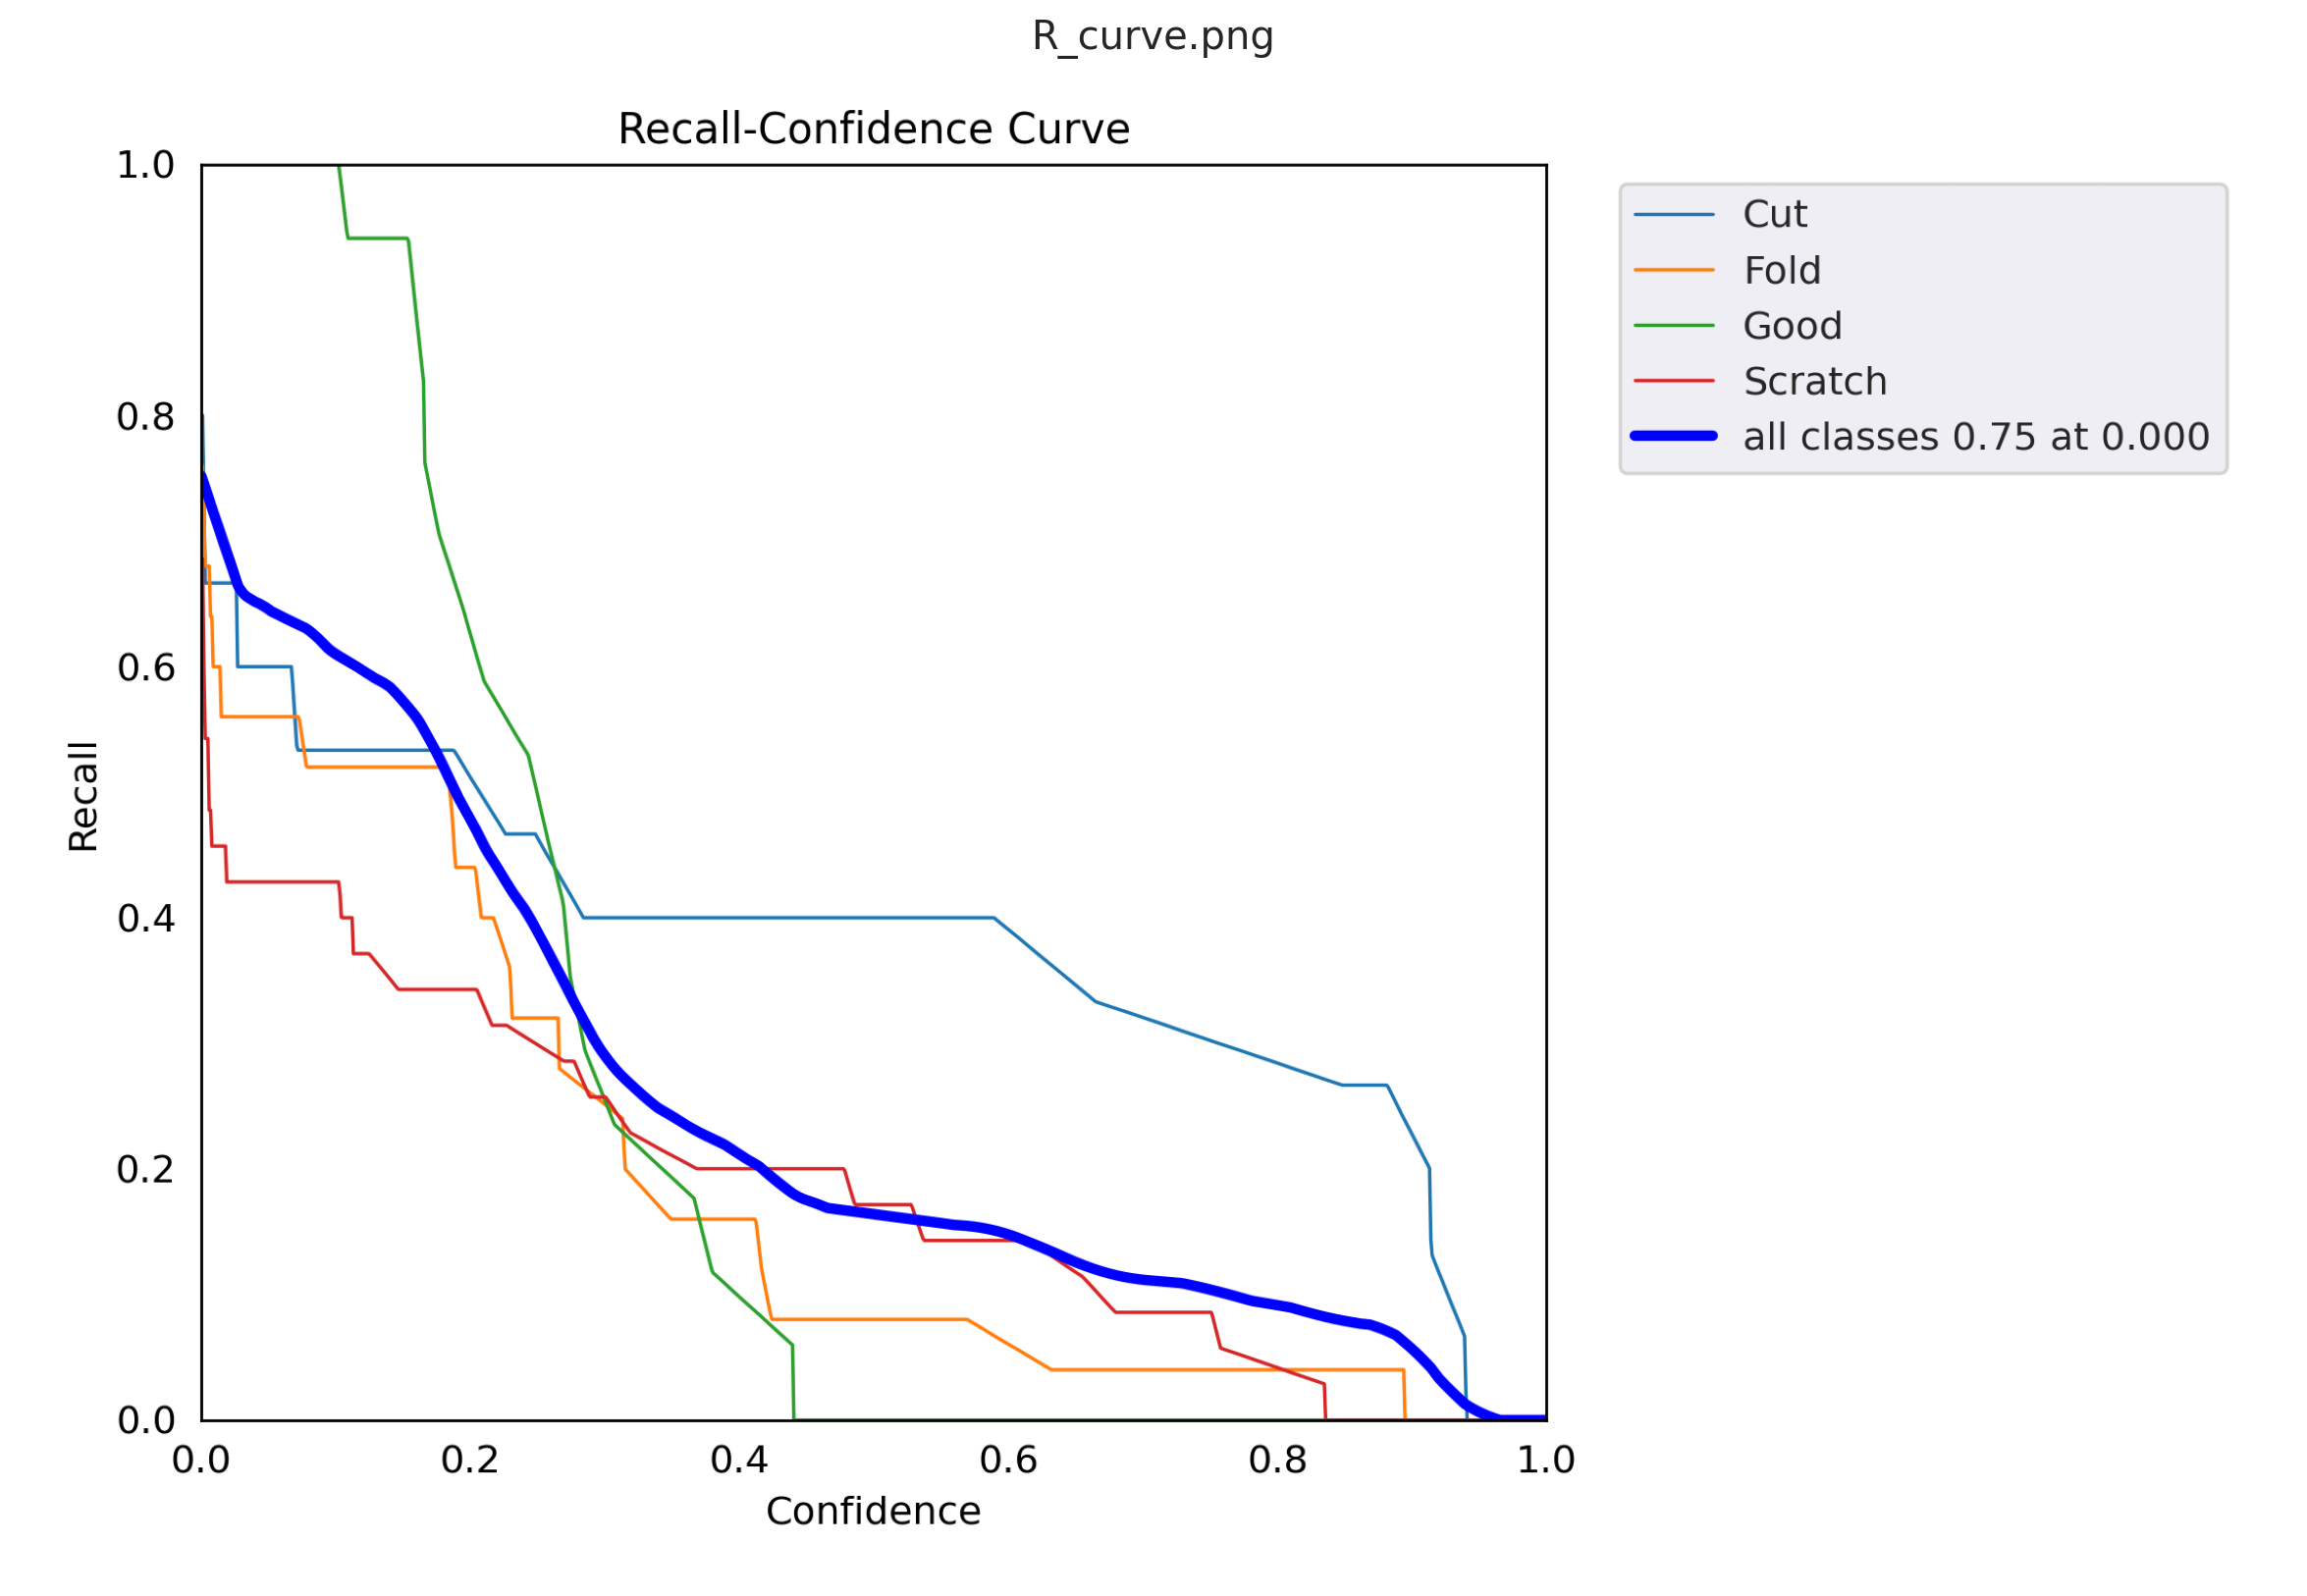

In [24]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set the directory path where the images are stored
directory = '/content/yolov5/runs/train/yolov5s_results'

# Iterate over the files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".png"):  # Check for .jpg files
        # Construct full file path
        file_path = os.path.join(directory, filename)
        # Load the image
        img = mpimg.imread(file_path)
        # Plot the image
        plt.imshow(img)
        plt.title(filename)
        plt.axis('off')  # Hide axes
        plt.show()
